In [39]:
import optuna
import os

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset,DataLoader,random_split
from torch.utils.tensorboard import SummaryWriter
from torchvision import models, transforms
from torch_lr_finder import LRFinder

import h5py
import copy
from datetime import datetime
import matplotlib.pyplot as plt

from Library.datasets import DatasetH5TwoRandom, DatasetH5ForTest, compute_std_mean
from Library.transforms import RandomFlip,RandomOffset,RandomRotateGrayscale
from Library.scheduler import OneCycleLR,LogLR
from Library.cresnet import initialize_cresnet
from Library.dml import RefBasedDeepMetric
from Library.models.FeatureExtractor import FeatureExtractor, Block, CustomNet
from Library.trainers import RefBasedDeepMetricTrainer
from tqdm.notebook import tqdm

In [2]:
from Library.util import (
    jupyter_wide_screen,
    strings_contain_words, 
    strings_contain_patterns, 
    add_unique_entry
)

jupyter_wide_screen()

In [3]:
def init_dataset(path,seq_idx_list,mean_val,std_val):

    ds_h5 = []
    refs_list = []

    img_transforms = [RandomRotateGrayscale(rot_range=[-0.1, 0.1], fill=150),
                      RandomFlip(lr_prob=0.5, ud_prob=0.5),
                      transforms.ToTensor(),
                      transforms.Normalize((mean_val,),(std_val,))]
    
    composed_img_transforms = transforms.Compose(img_transforms)
    
    # to obtain the Seq data
    for seq_idx in seq_idx_list:
        h5_fpath = path.format(seq_idx)
        h5_f = DatasetH5TwoRandom(h5_fpath,transform = composed_img_transforms)
        
        # obtain the references, the first 10 images in every Seq.
        refs = h5_f.getRef()
        refs_list.append(refs)
        
        ds_h5.append(h5_f)

    return refs_list, ds_h5

def init_dataloaders(datasets,ds_ratio):
    dataloaders = []
    
    for ds in datasets:
        splitted_ds_num_data = [round(len(ds) * ds_ratio[i]) for i in range(len(ds_ratio))]
        splitted_ds_num_data[0] += len(ds) - int(np.sum(splitted_ds_num_data))

        splitted_ds = []

        for tmp_ds, batch_size, shuffle in zip(random_split(ds, splitted_ds_num_data), batch_sizes, shuffle_flags):

            splitted_ds.append(
                DataLoader(
                    tmp_ds,
                    batch_size=batch_size,
                    shuffle=shuffle,
                    drop_last=True,
                )
            )

        dataloaders.append(splitted_ds)
    return dataloaders


# Load Model

In [4]:
model_path = 'optuna_models/RefFreeDeepMetric_Model_v6_old_3stride_t2'

In [5]:
with open(os.path.join(model_path, 'config.json')) as f:
    cresnet_config = json.load(f)
    
weight_fpath = os.path.join(model_path, 'model.weight')

device = torch.device("cuda:0")

In [6]:
cresnet_config

{'loss_non_linearity_name': 'sigmoid',
 'criterion_name': 'bce',
 'cresnet_config': {'InputShape': [1, 720, 24],
  'BlockName': 'LeakyBasicBlock',
  'NumBlocks': [3, 3, 3, 3, 3, 3, 3],
  'NumChannels': [24, 24, 48, 48, 96, 96, 192],
  'Strides': [[2, 2], [2, 2], [2, 1], [2, 2], [2, 2], [2, 1], [2, 1]],
  'NumNeurons': [32],
  'EnableGlobalAveragePooling': True,
  'PrintIntermediateShape': False,
  'InitializeResidual': True}}

In [7]:
model = RefBasedDeepMetric.load_pretrained_cresnet(model_path, device, show_config=True)

{'loss_non_linearity_name': 'sigmoid', 'criterion_name': 'bce', 'cresnet_config': {'InputShape': [1, 720, 24], 'BlockName': 'LeakyBasicBlock', 'NumBlocks': [3, 3, 3, 3, 3, 3, 3], 'NumChannels': [24, 24, 48, 48, 96, 96, 192], 'Strides': [[2, 2], [2, 2], [2, 1], [2, 2], [2, 2], [2, 1], [2, 1]], 'NumNeurons': [32], 'EnableGlobalAveragePooling': True, 'PrintIntermediateShape': False, 'InitializeResidual': True}}


In [8]:
model.to(device)

RefBasedDeepMetric(
  (feature_extractor): CResNet(
    (Block0): Sequential(
      (0): LeakyBasicBlock(
        (conv1): Conv2d(1, 24, kernel_size=(3, 3), stride=[2, 2], padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): LeakyReLU(negative_slope=0.01, inplace=True)
        (conv2): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (downsample): Sequential(
          (0): Conv2d(1, 24, kernel_size=(1, 1), stride=[2, 2], bias=False)
          (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): LeakyBasicBlock(
        (conv1): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

# Initial 1 stripe dataset

In [11]:
# 3 Stripes data -- Type 1
data_path_type1 = "../MA/NewData/22008_1000202026_652510007"
fnames_type1 = "Padding_regenerated_roi_ms1_seq{}_720x24.h5" # 0,1,2,3,4,5,6
combined_path_type1 = os.path.join(data_path_type1, fnames_type1)
seq_idx_list_type1 = [0,1,2,3,4,5,6]

In [12]:
#One Stripe Data -- Type 2
data_path_type2 = "../MA/NewData/21503_1000200411_653340003"
fnames_type2 = "trueroi_filtered_phase2_1_{}.h5" # 2,3,4
combined_path_type2 = os.path.join(data_path_type2, fnames_type2)
seq_idx_list_type2 = [2,3,4]

In [21]:
inputs_shape = [1,720,24]
batch_sizes = [32, 32, 32]
shuffle_flags = [True, False, False]
ds_ratio = [0.6, 0.2, 0.2]

In [22]:
mean_val = 0
std_val = 255
refs_list, ds_h5 = init_dataset(combined_path_type1, seq_idx_list_type1, mean_val, std_val)
refs_list_1stripe, ds_h5_1stripe = init_dataset(combined_path_type2, seq_idx_list_type2, mean_val, std_val)

In [23]:
# Combine the datasets for training
refs_list.insert(1,refs_list_1stripe[0])
refs_list.insert(3,refs_list_1stripe[1])
refs_list.insert(5,refs_list_1stripe[2])

ds_h5.insert(1,ds_h5_1stripe[0])
ds_h5.insert(3,ds_h5_1stripe[1])
ds_h5.insert(5,ds_h5_1stripe[2])

In [24]:
len(ds_h5)

10

In [25]:
dataloaders = init_dataloaders(ds_h5, ds_ratio)
train_dls = [dls[0] for dls in dataloaders]
valid_dls = [dls[1] for dls in dataloaders]
test_dls = [dls[2] for dls in dataloaders]

# LR test

In [26]:
from torch.optim.lr_scheduler import _LRScheduler
from torch_lr_finder import LRFinder ,TrainDataLoaderIter, ValDataLoaderIter

In [27]:
class CustomTrainIter(TrainDataLoaderIter):
    def inputs_labels_from_batch(self, batch_data):
        img1, img2, labels = batch_data
        return img1, img2, labels
    
    def __next__(self):
        try:
            batch = next(self._iterator)
            img1, img2, labels = self.inputs_labels_from_batch(batch)
        except StopIteration:
            if not self.auto_reset:
                raise
            self._iterator = iter(self.data_loader)
            batch = next(self._iterator)
            img1, img2, labels = self.inputs_labels_from_batch(batch)

        return img1, img2, labels

In [28]:
class CustomValIter(ValDataLoaderIter):
    def inputs_labels_from_batch(self, batch_data):
        img1, img2, labels = batch_data
        return img1, img2, labels

In [29]:
class LinearLR(_LRScheduler):
    """Linearly increases the learning rate between two boundaries over a number of
    iterations.

    Arguments:
        optimizer (torch.optim.Optimizer): wrapped optimizer.
        end_lr (float): the final learning rate.
        num_iter (int): the number of iterations over which the test occurs.
        last_epoch (int, optional): the index of last epoch. Default: -1.
    """

    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr

        if num_iter <= 1:
            raise ValueError("`num_iter` must be larger than 1")
        self.num_iter = num_iter

        super(LinearLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        r = self.last_epoch / (self.num_iter - 1)

        return [base_lr + r * (self.end_lr - base_lr) for base_lr in self.base_lrs]

In [30]:
class ExponentialLR(_LRScheduler):
    """Exponentially increases the learning rate between two boundaries over a number of
    iterations.

    Arguments:
        optimizer (torch.optim.Optimizer): wrapped optimizer.
        end_lr (float): the final learning rate.
        num_iter (int): the number of iterations over which the test occurs.
        last_epoch (int, optional): the index of last epoch. Default: -1.
    """

    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr

        if num_iter <= 1:
            raise ValueError("`num_iter` must be larger than 1")
        self.num_iter = num_iter

        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        # In earlier Pytorch versions last_epoch starts at -1, while in recent versions
        # it starts at 0. We need to adjust the math a bit to handle this. See
        # discussion at: https://github.com/davidtvs/pytorch-lr-finder/pull/42
        
        r = self.last_epoch / (self.num_iter - 1)

        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

In [31]:
try:
    from apex import amp

    IS_AMP_AVAILABLE = True
except ImportError:
    IS_AMP_AVAILABLE = False
    
class CustomLRFinder(LRFinder):
    
    def custom_range_test(
        self,
        train_loader,
        curr_refs,
        val_loader=None,
        start_lr=None,
        end_lr=10,
        num_iter=100,
        step_mode="exp",
        smooth_f=0.05,
        diverge_th=5,
        accumulation_steps=1,
        non_blocking_transfer=True,
    ):
       
        # Reset test results
        self.history = {"lr": [], "loss": []}
        self.best_loss = None

        # Move the model to the proper device
        self.model.to(self.device)

        # Check if the optimizer is already attached to a scheduler
        self._check_for_scheduler()

        # Set the starting learning rate
        if start_lr:
            self._set_learning_rate(start_lr)

        # Initialize the proper learning rate policy
        if step_mode.lower() == "exp":
            lr_schedule = ExponentialLR(self.optimizer, end_lr, num_iter)
        elif step_mode.lower() == "linear":
            lr_schedule = LinearLR(self.optimizer, end_lr, num_iter)
        else:
            raise ValueError("expected one of (exp, linear), got {}".format(step_mode))

        if smooth_f < 0 or smooth_f >= 1:
            raise ValueError("smooth_f is outside the range [0, 1[")

        # Create an iterator to get data batch by batch
        if isinstance(train_loader, DataLoader):
            train_iter = TrainDataLoaderIter(train_loader)
        elif isinstance(train_loader, TrainDataLoaderIter):
            train_iter = train_loader
        else:
            raise ValueError(
                "`train_loader` has unsupported type: {}."
                "Expected types are `torch.utils.data.DataLoader`"
                "or child of `TrainDataLoaderIter`.".format(type(train_loader))
            )

        if val_loader:
            if isinstance(val_loader, DataLoader):
                val_iter = CustomValIter(val_loader)
            elif isinstance(val_loader, ValDataLoaderIter):
                val_iter = val_loader
            else:
                raise ValueError(
                    "`val_loader` has unsupported type: {}."
                    "Expected types are `torch.utils.data.DataLoader`"
                    "or child of `ValDataLoaderIter`.".format(type(val_loader))
                )

        for iteration in tqdm(range(num_iter)):
            # Train on batch and retrieve loss
            loss = self._train_batch(
                train_iter,
                curr_refs,
                accumulation_steps,
                non_blocking_transfer= non_blocking_transfer,
            )
            if val_loader:
                loss = self._validate(
                    val_iter, curr_refs, non_blocking_transfer=non_blocking_transfer
                )

            # Update the learning rate
            self.history["lr"].append(lr_schedule.get_lr()[0])
            lr_schedule.step()

            # Track the best loss and smooth it if smooth_f is specified
            if iteration == 0:
                self.best_loss = loss
            else:
                if smooth_f > 0:
                    loss = smooth_f * loss + (1 - smooth_f) * self.history["loss"][-1]
                if loss < self.best_loss:
                    self.best_loss = loss

            # Check if the loss has diverged; if it has, stop the test
            self.history["loss"].append(loss)
            if loss > diverge_th * self.best_loss:
                print("Stopping early, the loss has diverged")
                break

        print("Learning rate search finished. See the graph with {finder_name}.plot()")

    def _train_batch(self, train_iter, curr_refs, accumulation_steps, non_blocking_transfer=True):
        self.model.train()
        total_loss = None  # for late initialization
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.optimizer.zero_grad()
        curr_refs = curr_refs.float().to(device)

        for i in range(accumulation_steps):
            img1, img2, labels = next(train_iter)
            labels = labels.view(-1)
            labels = labels.to(device)
            img1 = img1.float().to(device)
            img2 = img2.float().to(device)

            # Forward pass
            loss, preds = self.model.compute_loss(img1, img2, curr_refs, labels)

            # Loss should be averaged in each step
            loss /= accumulation_steps

            # Backward pass
            if IS_AMP_AVAILABLE and hasattr(self.optimizer, "_amp_stash"):
                # For minor performance optimization, see also:
                # https://nvidia.github.io/apex/advanced.html#gradient-accumulation-across-iterations
                delay_unscale = ((i + 1) % accumulation_steps) != 0

                with amp.scale_loss(
                    loss, self.optimizer, delay_unscale=delay_unscale
                ) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            if total_loss is None:
                total_loss = loss
            else:
                total_loss += loss

        self.optimizer.step()

        return total_loss.item()
    
    def _validate(self, val_iter, curr_refs, non_blocking_transfer=True):
        # Set model to evaluation mode and disable gradient computation
        running_loss = 0
        self.model.eval()
        
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        curr_refs = curr_refs.float().to(device)
        with torch.no_grad():
            for img1, img2, labels in val_iter:
                # Move data to the correct device
                labels = labels.view(-1)
                labels = labels.to(device)
                img1 = img1.float().to(device)
                img2 = img2.float().to(device)

                # Forward pass and loss computation
                loss, preds = self.model.compute_loss(img1, img2, curr_refs, labels)
                running_loss += loss.item() * len(labels)

        return running_loss / len(val_iter.dataset)
    

## LR test config

In [32]:
start_lr = 1e-8

min_lr_factor = 1e-1
anneal_lr_factor= 1e-1

train_dl_idx = 0
valid_dl_idx = 1
test_dl_idx = 2
refs_dl_idx = 0

optimizer = torch.optim.Adam(model.parameters(),lr=start_lr, eps=1e-08, weight_decay=0)
#optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, momentum=0.5)
#criterion = nn.CrossEntropyLoss()
#criterion = nn.BCEWithLogitsLoss(reduction = 'none')
criterion = nn.BCELoss()


Learning rate search finished. See the graph with {finder_name}.plot()


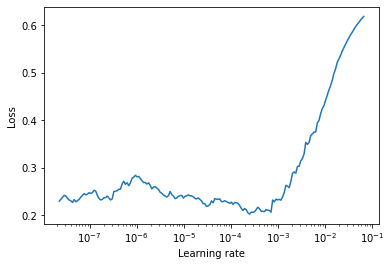

In [35]:
lr_finder.reset()
lr_finder = CustomLRFinder(model, optimizer, criterion, device="cuda")

# seq dataloader / shuffel the dataloader
for refs, train_dl, val_dl in zip (refs_list, train_dls, valid_dls):
    custom_train_iter = CustomTrainIter(train_dl)
    custom_val_iter = CustomValIter(val_dl)
lr_finder.custom_range_test(custom_train_iter, curr_refs = refs, end_lr=0.1, num_iter=200)
lr_finder.plot(suggest_lr = False)
lr_finder.reset()

In [37]:
num_epochs = 50

lr = 0.000316

min_lr_factor = 0.1
phases_ratio = [0.3, 0.2, 0.3, 0.2]

train_dl_idx = 0
valid_dl_idx = 1
test_dl_idx = 2

run_train = True

net_path = "../MA/save_net/"
criterion = nn.BCELoss()
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%d-%b-%Y (%H:%M:%S)")
print('Current Timestamp : ', timestampStr)

Current Timestamp :  28-May-2021 (10:24:00)


Total Train Iterations:  878
Total Train Iterations List:  [37, 152, 197, 278, 393, 508, 590, 687, 774, 878]
Valid iterations per seq:  [12, 38, 15, 27, 39, 38, 27, 33, 29, 34]


Train



Sequence:1, Seq Training Mean Loss: 0.27851171408956116, Seq Training Acc: 0.8859797297297297
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.7137533638788306, Seq Training Acc: 0.5355978260869565
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.25533905012740027, Seq Training Acc: 0.8861111111111111
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.6874366402626038, Seq Training Acc: 0.5466820987654321
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.279730953535308, Seq Training Acc: 0.8714673913043478
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.6449603238831396, Seq Training Acc: 0.6127717391304348
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.23591684777198768, Seq Training Acc: 0.899390243902439
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.23381652421865268, Seq Training Acc: 0.8981958762886598
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.2622054011999876, Seq Training Acc: 0.8832614942528736
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.1872485587373376, Seq Training Acc: 0.9206730769230769
******************************************************************
Epoch:1, Epoch Training Loss Mean: 0.3988722264766693, Epoch Training Acc: 0.7775484054669703
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.6252346436182658, Seq Valid Acc: 0.6953125



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.689345370782049, Seq Valid Acc: 0.5764802631578947



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.28720718721548716, Seq Valid Acc: 0.8666666666666667



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.7298487535229435, Seq Valid Acc: 0.5127314814814815



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.3719162039267711, Seq Valid Acc: 0.8301282051282052



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.8770187026575992, Seq Valid Acc: 0.5205592105263158



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.37818243437343174, Seq Valid Acc: 0.8217592592592593



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.35997136253299133, Seq Valid Acc: 0.8418560606060606



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.44591948801073533, Seq Valid Acc: 0.8243534482758621



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.31331391238114414, Seq Valid Acc: 0.8566176470588235
Epoch:1, Epoch Valid Mean Loss: 0.5178688764572144, Epoch Valid Acc: 0.7268835616438356
******************************************************************


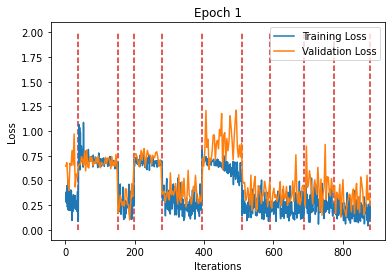

Train



Sequence:1, Seq Training Mean Loss: 0.194033155167425, Seq Training Acc: 0.9163851351351351
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.5688481271266937, Seq Training Acc: 0.6866847826086957
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.21434204644627042, Seq Training Acc: 0.8972222222222223
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.6171498357513805, Seq Training Acc: 0.6666666666666666
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.2654208719082501, Seq Training Acc: 0.8769021739130435
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.43088137624056444, Seq Training Acc: 0.8002717391304348
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.20319292785190954, Seq Training Acc: 0.9081554878048781
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.24090885201987533, Seq Training Acc: 0.8923969072164949
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.2503715429840417, Seq Training Acc: 0.8897270114942529
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.18481050309940025, Seq Training Acc: 0.9206730769230769
******************************************************************
Epoch:2, Epoch Training Loss Mean: 0.3340986669063568, Epoch Training Acc: 0.8363468109339408
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.7007869780063629, Seq Valid Acc: 0.6666666666666666



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.6455578756959814, Seq Valid Acc: 0.6578947368421053



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.2578802784283956, Seq Valid Acc: 0.8895833333333333



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.6878501066455135, Seq Valid Acc: 0.5601851851851852



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.4412969992710994, Seq Valid Acc: 0.7884615384615384



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.8133716379341326, Seq Valid Acc: 0.4967105263157895



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.3962038004839862, Seq Valid Acc: 0.8206018518518519



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.3716375529766083, Seq Valid Acc: 0.8409090909090909



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.3956240775256321, Seq Valid Acc: 0.8146551724137931



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.30266551980200934, Seq Valid Acc: 0.8667279411764706
Epoch:2, Epoch Valid Mean Loss: 0.5076190233230591, Epoch Valid Acc: 0.7331977739726028
******************************************************************


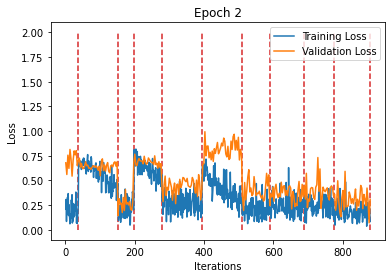

Train



Sequence:1, Seq Training Mean Loss: 0.19773149872953827, Seq Training Acc: 0.9163851351351351
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.3891339365554892, Seq Training Acc: 0.8269021739130434
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.19683460311757195, Seq Training Acc: 0.9097222222222222
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.5182215825275138, Seq Training Acc: 0.7430555555555556
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.2576657557617063, Seq Training Acc: 0.8847826086956522
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.3030298016641451, Seq Training Acc: 0.8646739130434783
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.21399220787897344, Seq Training Acc: 0.9047256097560976
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.23071391999567906, Seq Training Acc: 0.8927190721649485
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.2469247551313762, Seq Training Acc: 0.8943965517241379
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.17815639823675156, Seq Training Acc: 0.9224759615384616
******************************************************************
Epoch:3, Epoch Training Loss Mean: 0.281682550907135, Epoch Training Acc: 0.8722593963553531
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.6437303796410561, Seq Valid Acc: 0.6848958333333334



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.6608009683458429, Seq Valid Acc: 0.6266447368421053



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.3051120102405548, Seq Valid Acc: 0.8583333333333333



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.6850214468108283, Seq Valid Acc: 0.5648148148148148



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.4804988579872327, Seq Valid Acc: 0.7612179487179487



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.825001343300468, Seq Valid Acc: 0.48026315789473684



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.45522319387506555, Seq Valid Acc: 0.8032407407407407



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.3734222379597751, Seq Valid Acc: 0.8276515151515151



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.46421691364255446, Seq Valid Acc: 0.7769396551724138



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.3285488832522841, Seq Valid Acc: 0.8492647058823529
Epoch:3, Epoch Valid Mean Loss: 0.5316570997238159, Epoch Valid Acc: 0.714041095890411
******************************************************************


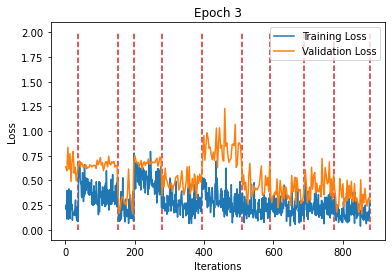

Train



Sequence:1, Seq Training Mean Loss: 0.1836219762225409, Seq Training Acc: 0.9256756756756757
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.32985948609269183, Seq Training Acc: 0.8483695652173913
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.23346337924400964, Seq Training Acc: 0.9006944444444445
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.45699042449762795, Seq Training Acc: 0.7719907407407407
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.27673826528632123, Seq Training Acc: 0.8733695652173913
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.2758461647707483, Seq Training Acc: 0.8758152173913043
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.22877939826831584, Seq Training Acc: 0.8959603658536586
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.2516047862387195, Seq Training Acc: 0.885631443298969
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.27128659539866723, Seq Training Acc: 0.884698275862069
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.18611373290276298, Seq Training Acc: 0.9203725961538461
******************************************************************
Epoch:4, Epoch Training Loss Mean: 0.27553585171699524, Epoch Training Acc: 0.8748220387243736
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.48887718965609867, Seq Valid Acc: 0.7786458333333334



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.760280789513337, Seq Valid Acc: 0.6644736842105263



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.26209103961785635, Seq Valid Acc: 0.86875



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.8060610051508303, Seq Valid Acc: 0.5300925925925926



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.5541621935673249, Seq Valid Acc: 0.6979166666666666



******************************************************************
Sequence:6, Seq Valid Mean Loss: 1.8624179551475926, Seq Valid Acc: 0.48273026315789475



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.47269539810993055, Seq Valid Acc: 0.7858796296296297



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.36528763445940887, Seq Valid Acc: 0.8484848484848485



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.43438788272183515, Seq Valid Acc: 0.7952586206896551



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.2434313647887286, Seq Valid Acc: 0.8897058823529411
Epoch:4, Epoch Valid Mean Loss: 0.6798890233039856, Epoch Valid Acc: 0.719285102739726
******************************************************************


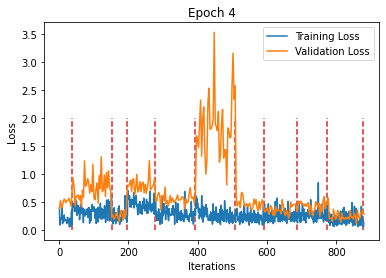

Train



Sequence:1, Seq Training Mean Loss: 0.22928604141280456, Seq Training Acc: 0.9011824324324325
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.30946023004210516, Seq Training Acc: 0.8557065217391304
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.22953646663162444, Seq Training Acc: 0.8993055555555556
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.42383824472810017, Seq Training Acc: 0.8113425925925926
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.2605246319071106, Seq Training Acc: 0.88125
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.24772395673005476, Seq Training Acc: 0.8899456521739131
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.24229960656929306, Seq Training Acc: 0.8871951219512195
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.2439341981386401, Seq Training Acc: 0.8923969072164949
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.26565002752789135, Seq Training Acc: 0.8850574712643678
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.19432490193643248, Seq Training Acc: 0.9185697115384616
******************************************************************
Epoch:5, Epoch Training Loss Mean: 0.26655086874961853, Epoch Training Acc: 0.8809439066059226
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.6075236946344376, Seq Valid Acc: 0.6770833333333334



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.8670775247247595, Seq Valid Acc: 0.6217105263157895



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.29627082745234173, Seq Valid Acc: 0.8604166666666667



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.8756381935543485, Seq Valid Acc: 0.5578703703703703



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.5837442278862, Seq Valid Acc: 0.6875



******************************************************************
Sequence:6, Seq Valid Mean Loss: 1.7516851613396092, Seq Valid Acc: 0.4662828947368421



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.41436969571643406, Seq Valid Acc: 0.8067129629629629



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.3644421335422631, Seq Valid Acc: 0.8314393939393939



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.5118778954292166, Seq Valid Acc: 0.7737068965517241



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.32641932499759335, Seq Valid Acc: 0.8556985294117647
Epoch:5, Epoch Valid Mean Loss: 0.7082632184028625, Epoch Valid Acc: 0.702054794520548
******************************************************************


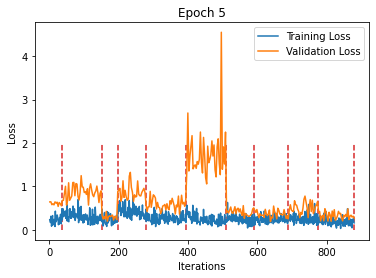

Train



Sequence:1, Seq Training Mean Loss: 0.23583775980247035, Seq Training Acc: 0.8961148648648649
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.29219056335480315, Seq Training Acc: 0.8706521739130435
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.21188585145605934, Seq Training Acc: 0.9055555555555556
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.40698649485905963, Seq Training Acc: 0.8040123456790124
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.28105768976004225, Seq Training Acc: 0.875
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.2437238214456517, Seq Training Acc: 0.8929347826086956
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.2592353204764971, Seq Training Acc: 0.8868140243902439
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.26512544179700087, Seq Training Acc: 0.8782216494845361
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.26833344088203603, Seq Training Acc: 0.8746408045977011
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.1949613129791732, Seq Training Acc: 0.9152644230769231
******************************************************************
Epoch:6, Epoch Training Loss Mean: 0.268535315990448, Epoch Training Acc: 0.8788795558086561
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.47845232983430225, Seq Valid Acc: 0.7942708333333334



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.6653933666254345, Seq Valid Acc: 0.6233552631578947



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.28737023373444875, Seq Valid Acc: 0.8708333333333333



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.6957669236041881, Seq Valid Acc: 0.5173611111111112



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.607750531954643, Seq Valid Acc: 0.6538461538461539



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.7131294859083075, Seq Valid Acc: 0.5049342105263158



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.45205588914729933, Seq Valid Acc: 0.7916666666666666



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.3694339737747655, Seq Valid Acc: 0.8248106060606061



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.42709237337112427, Seq Valid Acc: 0.7941810344827587



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.2542826285695328, Seq Valid Acc: 0.8952205882352942
Epoch:6, Epoch Valid Mean Loss: 0.5149039626121521, Epoch Valid Acc: 0.708904109589041
******************************************************************


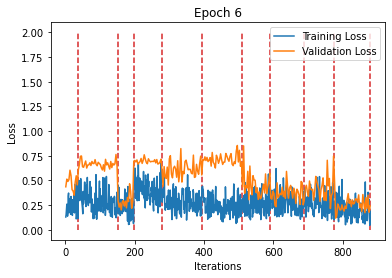

Train



Sequence:1, Seq Training Mean Loss: 0.24523634826009338, Seq Training Acc: 0.8902027027027027
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.3038433588069418, Seq Training Acc: 0.8592391304347826
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.20855313738187153, Seq Training Acc: 0.9069444444444444
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.38983957248705403, Seq Training Acc: 0.816358024691358
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.2960625750863034, Seq Training Acc: 0.8625
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.20782700381849123, Seq Training Acc: 0.9065217391304348
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.24590886184355107, Seq Training Acc: 0.8891006097560976
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.25763921224579367, Seq Training Acc: 0.8882087628865979
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.29563550051601456, Seq Training Acc: 0.8635057471264368
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.21595701274390405, Seq Training Acc: 0.9059495192307693
******************************************************************
Epoch:7, Epoch Training Loss Mean: 0.2690891623497009, Epoch Training Acc: 0.8775982346241458
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.7914367417494456, Seq Valid Acc: 0.5885416666666666



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.6621417575760892, Seq Valid Acc: 0.6529605263157895



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.2894232879082362, Seq Valid Acc: 0.8854166666666666



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.6946398063942238, Seq Valid Acc: 0.5416666666666666



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.6196650633445153, Seq Valid Acc: 0.6666666666666666



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.7390287487130416, Seq Valid Acc: 0.5254934210526315



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.55193915632036, Seq Valid Acc: 0.7372685185185185



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.3987032247312141, Seq Valid Acc: 0.8428030303030303



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.5729635337303425, Seq Valid Acc: 0.7392241379310345



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.332921341938131, Seq Valid Acc: 0.8483455882352942
Epoch:7, Epoch Valid Mean Loss: 0.5684935450553894, Epoch Valid Acc: 0.6977739726027398
******************************************************************


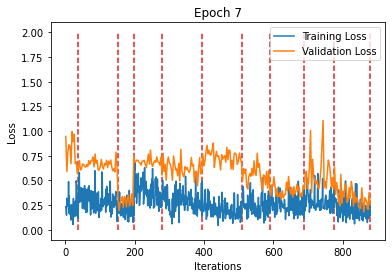

Train



Sequence:1, Seq Training Mean Loss: 0.24329370381058874, Seq Training Acc: 0.8961148648648649
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.291830167044764, Seq Training Acc: 0.8625
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.21266371260086694, Seq Training Acc: 0.9076388888888889
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.3858086402401512, Seq Training Acc: 0.8186728395061729
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.2936482116580009, Seq Training Acc: 0.8630434782608696
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.2129316285252571, Seq Training Acc: 0.9070652173913043
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.258722338916325, Seq Training Acc: 0.8784298780487805
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.2800754388583075, Seq Training Acc: 0.8711340206185567
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.29319937347338115, Seq Training Acc: 0.8706896551724138
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.2246755535642688, Seq Training Acc: 0.8996394230769231
******************************************************************
Epoch:8, Epoch Training Loss Mean: 0.27209171652793884, Epoch Training Acc: 0.8757474373576309
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.4879291156927745, Seq Valid Acc: 0.7864583333333334



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.6608185391677054, Seq Valid Acc: 0.6587171052631579



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.33286313017209374, Seq Valid Acc: 0.85



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.7148254005997269, Seq Valid Acc: 0.5092592592592593



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.4725927932140155, Seq Valid Acc: 0.7764423076923077



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.9637272938301689, Seq Valid Acc: 0.5082236842105263



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.4794867005613115, Seq Valid Acc: 0.7719907407407407



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.38618559458039026, Seq Valid Acc: 0.834280303030303



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.4552616384522668, Seq Valid Acc: 0.7801724137931034



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.30345705283038754, Seq Valid Acc: 0.8630514705882353
Epoch:8, Epoch Valid Mean Loss: 0.5463103652000427, Epoch Valid Acc: 0.7222816780821918
******************************************************************


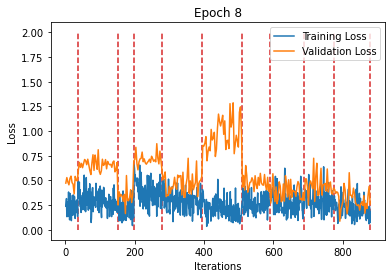

Train



Sequence:1, Seq Training Mean Loss: 0.24575770545650172, Seq Training Acc: 0.8944256756756757
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.27475472889516667, Seq Training Acc: 0.8741847826086957
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.23372142960627873, Seq Training Acc: 0.8965277777777778
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.37934042623749487, Seq Training Acc: 0.8229166666666666
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.30024013273094013, Seq Training Acc: 0.8644021739130435
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.19267780754877173, Seq Training Acc: 0.9168478260869565
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.27745299286595204, Seq Training Acc: 0.875
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.2826779467082515, Seq Training Acc: 0.8795103092783505
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.3259979847861432, Seq Training Acc: 0.853448275862069
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.21115569200796577, Seq Training Acc: 0.9077524038461539
******************************************************************
Epoch:9, Epoch Training Loss Mean: 0.27233755588531494, Epoch Training Acc: 0.8783456719817767
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.5355353405078253, Seq Valid Acc: 0.7760416666666666



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.6699571923205727, Seq Valid Acc: 0.6126644736842105



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.313734295964241, Seq Valid Acc: 0.8791666666666667



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.7158858776092529, Seq Valid Acc: 0.47337962962962965



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.5683706104755402, Seq Valid Acc: 0.7043269230769231



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.7668781202090414, Seq Valid Acc: 0.5115131578947368



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.5632148075986791, Seq Valid Acc: 0.71875



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.4575467227083264, Seq Valid Acc: 0.7916666666666666



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.489735313530626, Seq Valid Acc: 0.7618534482758621



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.2670741913949742, Seq Valid Acc: 0.8915441176470589
Epoch:9, Epoch Valid Mean Loss: 0.5507405996322632, Epoch Valid Acc: 0.6965967465753424
******************************************************************


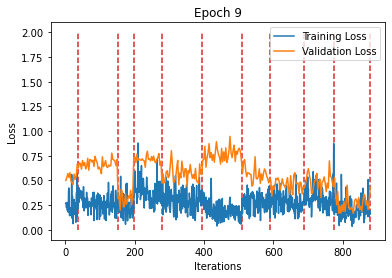

Train



Sequence:1, Seq Training Mean Loss: 0.22914196309205648, Seq Training Acc: 0.9003378378378378
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.27529636083737663, Seq Training Acc: 0.877445652173913
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.249948588013649, Seq Training Acc: 0.89375
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.38509526168122704, Seq Training Acc: 0.8070987654320988
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.2980338281263476, Seq Training Acc: 0.8608695652173913
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.1983618979220805, Seq Training Acc: 0.9141304347826087
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.281842700046737, Seq Training Acc: 0.864329268292683
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.27317302044212205, Seq Training Acc: 0.8785438144329897
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.3277832084688647, Seq Training Acc: 0.8599137931034483
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.20177152337363133, Seq Training Acc: 0.9113581730769231
******************************************************************
Epoch:10, Epoch Training Loss Mean: 0.2719515860080719, Epoch Training Acc: 0.8765660592255126
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.6490613470474879, Seq Valid Acc: 0.6796875



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.7734146510299883, Seq Valid Acc: 0.6134868421052632



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.34581652184327444, Seq Valid Acc: 0.8583333333333333



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.7969629455495764, Seq Valid Acc: 0.5578703703703703



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.42706792018352413, Seq Valid Acc: 0.8020833333333334



******************************************************************
Sequence:6, Seq Valid Mean Loss: 1.3480492955759953, Seq Valid Acc: 0.48026315789473684



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.37072637401245256, Seq Valid Acc: 0.8368055555555556



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.37741054368741583, Seq Valid Acc: 0.8314393939393939



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.45462613886800307, Seq Valid Acc: 0.7758620689655172



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.31049182682352905, Seq Valid Acc: 0.8648897058823529
Epoch:10, Epoch Valid Mean Loss: 0.6094873547554016, Epoch Valid Acc: 0.7221746575342466
******************************************************************


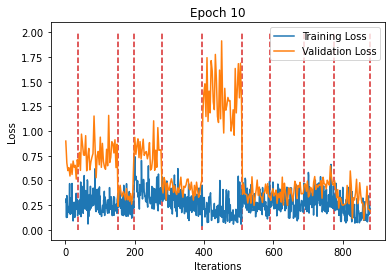

Train



Sequence:1, Seq Training Mean Loss: 0.23321609682327993, Seq Training Acc: 0.9028716216216216
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.27448839363844496, Seq Training Acc: 0.8804347826086957
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.23428365819984012, Seq Training Acc: 0.8993055555555556
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.3554032235233872, Seq Training Acc: 0.8368055555555556
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.2917481774545234, Seq Training Acc: 0.8660326086956521
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.18321272815051287, Seq Training Acc: 0.9222826086956522
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.2761882936082235, Seq Training Acc: 0.870045731707317
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.2557978038628077, Seq Training Acc: 0.8853092783505154
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.2779346332810391, Seq Training Acc: 0.8735632183908046
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.2172835675569681, Seq Training Acc: 0.9074519230769231
******************************************************************
Epoch:11, Epoch Training Loss Mean: 0.26011812686920166, Epoch Training Acc: 0.884004840546697
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.6530108054478964, Seq Valid Acc: 0.7265625



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.7556790419315037, Seq Valid Acc: 0.6529605263157895



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.3043359061082204, Seq Valid Acc: 0.8708333333333333



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.8537997548226957, Seq Valid Acc: 0.5451388888888888



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.48570044529743683, Seq Valid Acc: 0.7628205128205128



******************************************************************
Sequence:6, Seq Valid Mean Loss: 1.65078320471864, Seq Valid Acc: 0.5115131578947368



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.5341454512543149, Seq Valid Acc: 0.7581018518518519



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.43839822845025495, Seq Valid Acc: 0.8304924242424242



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.47974673427384473, Seq Valid Acc: 0.7510775862068966



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.28768856911098256, Seq Valid Acc: 0.875
Epoch:11, Epoch Valid Mean Loss: 0.6795368790626526, Epoch Valid Acc: 0.7188570205479452
******************************************************************


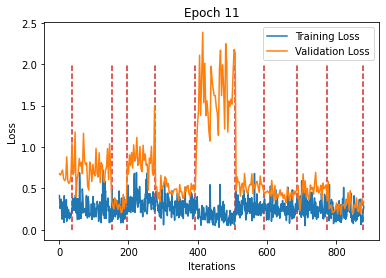

Train



Sequence:1, Seq Training Mean Loss: 0.23779336987314997, Seq Training Acc: 0.8961148648648649
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.24307814324679583, Seq Training Acc: 0.8929347826086956
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.25001511673132576, Seq Training Acc: 0.8770833333333333
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.34498281592940105, Seq Training Acc: 0.8290895061728395
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.2830024853348732, Seq Training Acc: 0.8739130434782608
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.16833699828256732, Seq Training Acc: 0.9252717391304348
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.2566379675777947, Seq Training Acc: 0.8734756097560976
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.27636796873562114, Seq Training Acc: 0.8762886597938144
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.30236553734746474, Seq Training Acc: 0.8699712643678161
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.22161177144600794, Seq Training Acc: 0.9029447115384616
******************************************************************
Epoch:12, Epoch Training Loss Mean: 0.25632813572883606, Epoch Training Acc: 0.8833641799544419
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.5704443405071894, Seq Valid Acc: 0.7291666666666666



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.724046882830168, Seq Valid Acc: 0.5205592105263158



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.31409939328829445, Seq Valid Acc: 0.875



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.7437580779746726, Seq Valid Acc: 0.5150462962962963



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.5237866899906061, Seq Valid Acc: 0.7323717948717948



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.7643839826709345, Seq Valid Acc: 0.506578947368421



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.5567435357305739, Seq Valid Acc: 0.7175925925925926



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.41611991958184674, Seq Valid Acc: 0.8248106060606061



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.5092651134934919, Seq Valid Acc: 0.7435344827586207



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.2947927516172914, Seq Valid Acc: 0.8887867647058824
Epoch:12, Epoch Valid Mean Loss: 0.5554178953170776, Epoch Valid Acc: 0.6909246575342466
******************************************************************


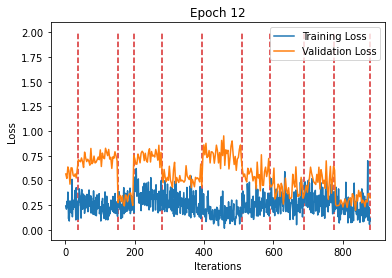

Train



Sequence:1, Seq Training Mean Loss: 0.24503860914626638, Seq Training Acc: 0.9003378378378378
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.25063627057749294, Seq Training Acc: 0.8845108695652174
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.2597666500343217, Seq Training Acc: 0.8847222222222222
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.31449590375026065, Seq Training Acc: 0.8576388888888888
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.29689111061718154, Seq Training Acc: 0.8595108695652174
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.1700271803399791, Seq Training Acc: 0.9255434782608696
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.2620311777402715, Seq Training Acc: 0.881859756097561
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.252053979592225, Seq Training Acc: 0.8878865979381443
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.30005691157675335, Seq Training Acc: 0.8692528735632183
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.2194841277355758, Seq Training Acc: 0.9026442307692307
******************************************************************
Epoch:13, Epoch Training Loss Mean: 0.2546878755092621, Epoch Training Acc: 0.8855708997722096
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.530226394534111, Seq Valid Acc: 0.7473958333333334



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.6944725482087386, Seq Valid Acc: 0.5460526315789473



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.27907308340072634, Seq Valid Acc: 0.89375



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.702718644230454, Seq Valid Acc: 0.5162037037037037



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.46021971641442716, Seq Valid Acc: 0.7836538461538461



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.7687750584200809, Seq Valid Acc: 0.5139802631578947



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.5340166710041188, Seq Valid Acc: 0.7627314814814815



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.4575484837546493, Seq Valid Acc: 0.7831439393939394



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.47803305243623667, Seq Valid Acc: 0.7650862068965517



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.21629749873981757, Seq Valid Acc: 0.9117647058823529
Epoch:13, Epoch Valid Mean Loss: 0.5267425179481506, Epoch Valid Acc: 0.7081549657534246
******************************************************************


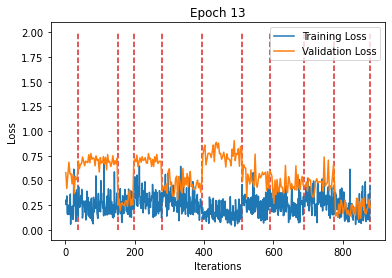

Train



Sequence:1, Seq Training Mean Loss: 0.23061625880969538, Seq Training Acc: 0.8994932432432432
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.2612944228493649, Seq Training Acc: 0.8913043478260869
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.2340414164794816, Seq Training Acc: 0.8993055555555556
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.332545045533298, Seq Training Acc: 0.8580246913580247
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.2832200305617374, Seq Training Acc: 0.8684782608695653
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.16840708472806473, Seq Training Acc: 0.9247282608695652
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.2599819894970917, Seq Training Acc: 0.8868140243902439
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.27764989643060056, Seq Training Acc: 0.8814432989690721
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.3017894520327963, Seq Training Acc: 0.865301724137931
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.21435772229988986, Seq Training Acc: 0.9077524038461539
******************************************************************
Epoch:14, Epoch Training Loss Mean: 0.25602078437805176, Epoch Training Acc: 0.8882403189066059
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.49835136036078137, Seq Valid Acc: 0.7994791666666666



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.6419143833612141, Seq Valid Acc: 0.6480263157894737



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.3006393661101659, Seq Valid Acc: 0.86875



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.7000134763894258, Seq Valid Acc: 0.5150462962962963



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.4886061938909384, Seq Valid Acc: 0.7844551282051282



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.7831217960307473, Seq Valid Acc: 0.49917763157894735



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.4664390363075115, Seq Valid Acc: 0.7893518518518519



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.39535313031890174, Seq Valid Acc: 0.8087121212121212



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.43208824046726885, Seq Valid Acc: 0.8081896551724138



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.2687629172030617, Seq Valid Acc: 0.8970588235294118
Epoch:14, Epoch Valid Mean Loss: 0.5133773684501648, Epoch Valid Acc: 0.7282748287671232
******************************************************************


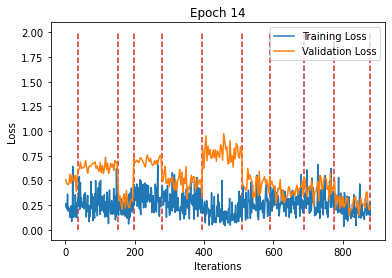

Train



Sequence:1, Seq Training Mean Loss: 0.22189624073940353, Seq Training Acc: 0.9087837837837838
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.2528021616132363, Seq Training Acc: 0.8866847826086957
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.25692081203063327, Seq Training Acc: 0.8847222222222222
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.3189695137150494, Seq Training Acc: 0.8614969135802469
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.2981096116097077, Seq Training Acc: 0.8635869565217391
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.14789996651689644, Seq Training Acc: 0.9323369565217391
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.25316485044796294, Seq Training Acc: 0.8860518292682927
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.26485955200551714, Seq Training Acc: 0.885631443298969
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.29159934912947405, Seq Training Acc: 0.8714080459770115
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.21956736999205673, Seq Training Acc: 0.9074519230769231
******************************************************************
Epoch:15, Epoch Training Loss Mean: 0.25128304958343506, Epoch Training Acc: 0.8889165717539863
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.5173657337824503, Seq Valid Acc: 0.7473958333333334



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.6732896142884305, Seq Valid Acc: 0.6192434210526315



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.29480266869068145, Seq Valid Acc: 0.8833333333333333



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.6930251386430528, Seq Valid Acc: 0.5115740740740741



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.5125509798526764, Seq Valid Acc: 0.7475961538461539



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.7177728132197732, Seq Valid Acc: 0.4753289473684211



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.528617791555546, Seq Valid Acc: 0.7453703703703703



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.4222557842731476, Seq Valid Acc: 0.8096590909090909



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.5065719875796088, Seq Valid Acc: 0.7629310344827587



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.2674332944785847, Seq Valid Acc: 0.8933823529411765
Epoch:15, Epoch Valid Mean Loss: 0.5280219316482544, Epoch Valid Acc: 0.7059075342465754
******************************************************************


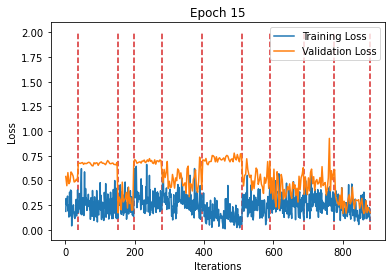

Train



Sequence:1, Seq Training Mean Loss: 0.23025041456158096, Seq Training Acc: 0.8986486486486487
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.22209167982573094, Seq Training Acc: 0.8994565217391305
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.2439276425374879, Seq Training Acc: 0.8944444444444445
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.3233597269396723, Seq Training Acc: 0.8530092592592593
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.2944458204766978, Seq Training Acc: 0.8584239130434783
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.14729894419079242, Seq Training Acc: 0.938858695652174
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.27653545395630164, Seq Training Acc: 0.8727134146341463
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.26848495874515516, Seq Training Acc: 0.876610824742268
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.31050839095280086, Seq Training Acc: 0.8642241379310345
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.20068689675715107, Seq Training Acc: 0.9113581730769231
******************************************************************
Epoch:16, Epoch Training Loss Mean: 0.24901361763477325, Epoch Training Acc: 0.8875640660592256
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.5345195208986601, Seq Valid Acc: 0.7552083333333334



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.7088018640091545, Seq Valid Acc: 0.524671052631579



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.3139171948035558, Seq Valid Acc: 0.8770833333333333



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.714417161764922, Seq Valid Acc: 0.48842592592592593



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.47697176077427006, Seq Valid Acc: 0.7676282051282052



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.7311909841863733, Seq Valid Acc: 0.5304276315789473



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.4799962904718187, Seq Valid Acc: 0.7662037037037037



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.47198287826595886, Seq Valid Acc: 0.7821969696969697



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.42885126019346304, Seq Valid Acc: 0.8092672413793104



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.3003668570343186, Seq Valid Acc: 0.8658088235294118
Epoch:16, Epoch Valid Mean Loss: 0.5305423736572266, Epoch Valid Acc: 0.701519691780822
******************************************************************


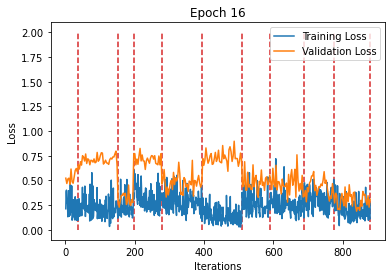

Train



Sequence:1, Seq Training Mean Loss: 0.26410835780001973, Seq Training Acc: 0.8834459459459459
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.2284145228240801, Seq Training Acc: 0.9002717391304348
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.2496812093589041, Seq Training Acc: 0.8895833333333333
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.34060394340827144, Seq Training Acc: 0.84375
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.2757790611489959, Seq Training Acc: 0.8744565217391305
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.14106764001366884, Seq Training Acc: 0.941304347826087
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.26319494361921053, Seq Training Acc: 0.8814786585365854
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.26685429141693506, Seq Training Acc: 0.8833762886597938
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.26986138111558455, Seq Training Acc: 0.8778735632183908
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.18263316107913852, Seq Training Acc: 0.9215745192307693
******************************************************************
Epoch:17, Epoch Training Loss Mean: 0.24230098724365234, Epoch Training Acc: 0.8924757972665148
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.5332040240367254, Seq Valid Acc: 0.7447916666666666



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.7005519521863837, Seq Valid Acc: 0.5485197368421053



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.23664399186770121, Seq Valid Acc: 0.89375



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.7144479310071027, Seq Valid Acc: 0.47685185185185186



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.4824611254227467, Seq Valid Acc: 0.7628205128205128



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.698171981071171, Seq Valid Acc: 0.5180921052631579



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.44828174070075705, Seq Valid Acc: 0.7997685185185185



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.3866988447579471, Seq Valid Acc: 0.8257575757575758



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.4650224534602001, Seq Valid Acc: 0.8017241379310345



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.28510893530705395, Seq Valid Acc: 0.8667279411764706
Epoch:17, Epoch Valid Mean Loss: 0.5111291408538818, Epoch Valid Acc: 0.7091181506849316
******************************************************************


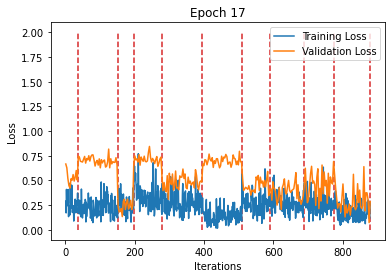

Train



Sequence:1, Seq Training Mean Loss: 0.248138647023085, Seq Training Acc: 0.8952702702702703
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.22961036912772967, Seq Training Acc: 0.897554347826087
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.25549175408151414, Seq Training Acc: 0.8875
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.29347156834455185, Seq Training Acc: 0.8703703703703703
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.2745613703261251, Seq Training Acc: 0.8722826086956522
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.14713869552411463, Seq Training Acc: 0.9339673913043478
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.2683194042524187, Seq Training Acc: 0.8769054878048781
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.27059164773864847, Seq Training Acc: 0.8827319587628866
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.2723727798324892, Seq Training Acc: 0.882183908045977
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.20752410538709506, Seq Training Acc: 0.9095552884615384
******************************************************************
Epoch:18, Epoch Training Loss Mean: 0.24245861172676086, Epoch Training Acc: 0.8922266514806378
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.442037637035052, Seq Valid Acc: 0.8203125



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.8231966166119826, Seq Valid Acc: 0.6570723684210527



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.3523344953854879, Seq Valid Acc: 0.8479166666666667



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.9646887624705279, Seq Valid Acc: 0.6111111111111112



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.48333990344634425, Seq Valid Acc: 0.7596153846153846



******************************************************************
Sequence:6, Seq Valid Mean Loss: 1.7166347299751483, Seq Valid Acc: 0.5164473684210527



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.5741602149274614, Seq Valid Acc: 0.7141203703703703



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.43291419292941236, Seq Valid Acc: 0.7982954545454546



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.5008594434836815, Seq Valid Acc: 0.7306034482758621



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.2509447445764261, Seq Valid Acc: 0.8869485294117647
Epoch:18, Epoch Valid Mean Loss: 0.7015255093574524, Epoch Valid Acc: 0.7200342465753424
******************************************************************


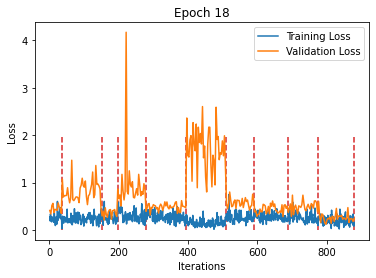

Train



Sequence:1, Seq Training Mean Loss: 0.2025580976057697, Seq Training Acc: 0.9096283783783784
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.21366783134315326, Seq Training Acc: 0.9046195652173913
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.23213522136211395, Seq Training Acc: 0.8902777777777777
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.2781292113624973, Seq Training Acc: 0.873070987654321
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.2810876830116562, Seq Training Acc: 0.8771739130434782
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.15135558576363584, Seq Training Acc: 0.9331521739130435
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.25896470012461265, Seq Training Acc: 0.8803353658536586
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.26657082770288604, Seq Training Acc: 0.8791881443298969
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.29687012800540047, Seq Training Acc: 0.8735632183908046
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.19925736363690633, Seq Training Acc: 0.9155649038461539
******************************************************************
Epoch:19, Epoch Training Loss Mean: 0.23737461864948273, Epoch Training Acc: 0.8944689635535308
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.6037239134311676, Seq Valid Acc: 0.7083333333333334



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.7057839286954779, Seq Valid Acc: 0.5797697368421053



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.25945510268211364, Seq Valid Acc: 0.8958333333333334



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.7366091476546394, Seq Valid Acc: 0.5196759259259259



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.5027935879352765, Seq Valid Acc: 0.7443910256410257



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.7507117249463734, Seq Valid Acc: 0.5213815789473685



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.4353340235021379, Seq Valid Acc: 0.7974537037037037



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.32632503455335443, Seq Valid Acc: 0.8503787878787878



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.595129714957599, Seq Valid Acc: 0.7413793103448276



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.30670081385794806, Seq Valid Acc: 0.8483455882352942
Epoch:19, Epoch Valid Mean Loss: 0.5348975658416748, Epoch Valid Acc: 0.7081549657534246
******************************************************************


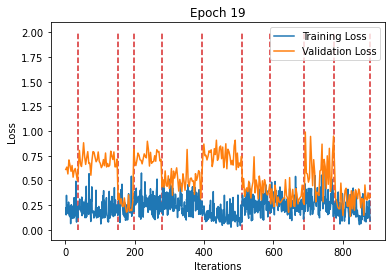

Train



Sequence:1, Seq Training Mean Loss: 0.23339724137976364, Seq Training Acc: 0.8944256756756757
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.21360026730791382, Seq Training Acc: 0.907608695652174
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.2517807991968261, Seq Training Acc: 0.8875
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.2563087826157794, Seq Training Acc: 0.8869598765432098
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.2758351890937142, Seq Training Acc: 0.8758152173913043
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.1455384618886139, Seq Training Acc: 0.9380434782608695
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.2574089252185531, Seq Training Acc: 0.8841463414634146
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.26168083960248023, Seq Training Acc: 0.8817654639175257
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.2916892062144718, Seq Training Acc: 0.8660201149425287
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.1910043907387612, Seq Training Acc: 0.9155649038461539
******************************************************************
Epoch:20, Epoch Training Loss Mean: 0.23403285443782806, Epoch Training Acc: 0.8957146924829157
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.6482773224512736, Seq Valid Acc: 0.6953125



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.697440034464786, Seq Valid Acc: 0.5583881578947368



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.28180325627326963, Seq Valid Acc: 0.875



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.7096699586621037, Seq Valid Acc: 0.5057870370370371



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.40138402046301425, Seq Valid Acc: 0.8245192307692307



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.7257336283984938, Seq Valid Acc: 0.4769736842105263



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.5319253846451089, Seq Valid Acc: 0.7511574074074074



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.4353356858094533, Seq Valid Acc: 0.8049242424242424



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.4378713718776045, Seq Valid Acc: 0.7974137931034483



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.24204886879991083, Seq Valid Acc: 0.8786764705882353
Epoch:20, Epoch Valid Mean Loss: 0.5156097412109375, Epoch Valid Acc: 0.7070847602739726
******************************************************************


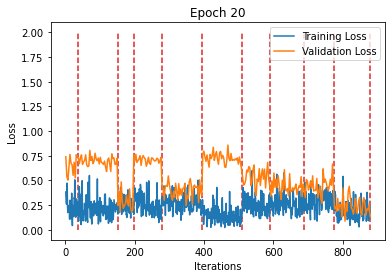

Train



Sequence:1, Seq Training Mean Loss: 0.2210590744743476, Seq Training Acc: 0.8910472972972973
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.23241817232059395, Seq Training Acc: 0.9021739130434783
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.2712826038400332, Seq Training Acc: 0.875
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.2619290829256729, Seq Training Acc: 0.8850308641975309
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.2711628324959589, Seq Training Acc: 0.8733695652173913
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.13666552878592325, Seq Training Acc: 0.9418478260869565
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.2523255561728303, Seq Training Acc: 0.8887195121951219
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.281550849682277, Seq Training Acc: 0.8762886597938144
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.26768180924928053, Seq Training Acc: 0.8868534482758621
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.19759558560326695, Seq Training Acc: 0.9134615384615384
******************************************************************
Epoch:21, Epoch Training Loss Mean: 0.23584385216236115, Epoch Training Acc: 0.8958570615034168
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.49862345059712726, Seq Valid Acc: 0.78125



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.6705133162046734, Seq Valid Acc: 0.6036184210526315



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.26843250741561253, Seq Valid Acc: 0.8729166666666667



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.7004271370393259, Seq Valid Acc: 0.5335648148148148



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.4874547788730034, Seq Valid Acc: 0.7732371794871795



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.6913586211831946, Seq Valid Acc: 0.5764802631578947



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.5260886726556001, Seq Valid Acc: 0.7685185185185185



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.3649895985921224, Seq Valid Acc: 0.8304924242424242



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.5615475794364666, Seq Valid Acc: 0.7489224137931034



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.2548784363795729, Seq Valid Acc: 0.8860294117647058
Epoch:21, Epoch Valid Mean Loss: 0.5167232155799866, Epoch Valid Acc: 0.7255993150684932
******************************************************************


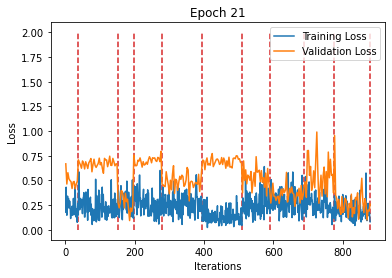

Train



Sequence:1, Seq Training Mean Loss: 0.23258183997225118, Seq Training Acc: 0.8961148648648649
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.20379712413186613, Seq Training Acc: 0.9095108695652174
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.24292721715238358, Seq Training Acc: 0.8895833333333333
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.2684183241224583, Seq Training Acc: 0.8780864197530864
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.27462086308261624, Seq Training Acc: 0.8766304347826087
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.13925862633015798, Seq Training Acc: 0.935054347826087
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.2536404057428604, Seq Training Acc: 0.8871951219512195
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.24257190798207656, Seq Training Acc: 0.8940077319587629
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.29309967177352686, Seq Training Acc: 0.8631465517241379
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.18518579769163176, Seq Training Acc: 0.9239783653846154
******************************************************************
Epoch:22, Epoch Training Loss Mean: 0.22938373684883118, Epoch Training Acc: 0.8973875284738041
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.608139472703139, Seq Valid Acc: 0.6848958333333334



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.6731217425120505, Seq Valid Acc: 0.5855263157894737



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.2369519611199697, Seq Valid Acc: 0.8916666666666667



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.7022889079871001, Seq Valid Acc: 0.5219907407407407



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.47040683031082153, Seq Valid Acc: 0.7756410256410257



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.7175648384972623, Seq Valid Acc: 0.5189144736842105



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.4620598703622818, Seq Valid Acc: 0.7916666666666666



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.3417246292034785, Seq Valid Acc: 0.8541666666666666



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.43548513280934303, Seq Valid Acc: 0.8103448275862069



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.2804859320030493, Seq Valid Acc: 0.8685661764705882
Epoch:22, Epoch Valid Mean Loss: 0.5031638145446777, Epoch Valid Acc: 0.7208904109589042
******************************************************************


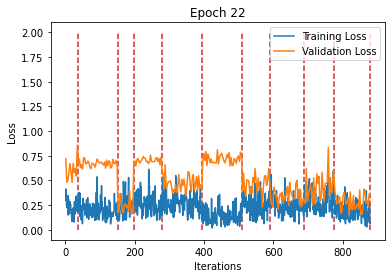

Train



Sequence:1, Seq Training Mean Loss: 0.22965932556906263, Seq Training Acc: 0.8910472972972973
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.22795960916125257, Seq Training Acc: 0.903804347826087
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.22582391616370942, Seq Training Acc: 0.8972222222222223
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.27077208790514207, Seq Training Acc: 0.873070987654321
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.277725861772247, Seq Training Acc: 0.8709239130434783
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.1320871477379747, Seq Training Acc: 0.9410326086956522
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.24169716775053884, Seq Training Acc: 0.8891006097560976
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.2641296079478313, Seq Training Acc: 0.8775773195876289
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.2710147951354926, Seq Training Acc: 0.8825431034482759
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.20195379093862498, Seq Training Acc: 0.9107572115384616
******************************************************************
Epoch:23, Epoch Training Loss Mean: 0.2322973757982254, Epoch Training Acc: 0.8951096241457859
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.6912149687608083, Seq Valid Acc: 0.6380208333333334



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.6694475835875461, Seq Valid Acc: 0.6291118421052632



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.280293603738149, Seq Valid Acc: 0.88125



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.6992002615222225, Seq Valid Acc: 0.5370370370370371



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.43890479359871304, Seq Valid Acc: 0.7932692307692307



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.759064793586731, Seq Valid Acc: 0.5



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.41992244786686367, Seq Valid Acc: 0.7939814814814815



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.3761251966158549, Seq Valid Acc: 0.8248106060606061



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.4534218167436534, Seq Valid Acc: 0.7952586206896551



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.2523059969877495, Seq Valid Acc: 0.8768382352941176
Epoch:23, Epoch Valid Mean Loss: 0.5077254176139832, Epoch Valid Acc: 0.7217465753424658
******************************************************************


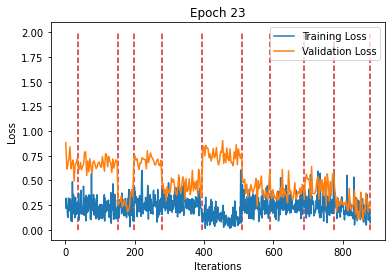

Train



Sequence:1, Seq Training Mean Loss: 0.22930471901152585, Seq Training Acc: 0.8893581081081081
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.2319634471250617, Seq Training Acc: 0.8956521739130435
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.2296716189218892, Seq Training Acc: 0.8930555555555556
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.25983862873212793, Seq Training Acc: 0.8908179012345679
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.2635714030784109, Seq Training Acc: 0.8809782608695652
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.14763292315537516, Seq Training Acc: 0.9347826086956522
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.23173503654940827, Seq Training Acc: 0.899390243902439
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.26093014037793444, Seq Training Acc: 0.8814432989690721
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.27744402813500374, Seq Training Acc: 0.8760775862068966
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.18655600405942935, Seq Training Acc: 0.9170673076923077
******************************************************************
Epoch:24, Epoch Training Loss Mean: 0.22970692813396454, Epoch Training Acc: 0.8973875284738041
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.625696728626887, Seq Valid Acc: 0.6536458333333334



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.8237223719295702, Seq Valid Acc: 0.6044407894736842



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.27506893277168276, Seq Valid Acc: 0.86875



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.8266326255268521, Seq Valid Acc: 0.5254629629629629



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.45013058414826024, Seq Valid Acc: 0.7892628205128205



******************************************************************
Sequence:6, Seq Valid Mean Loss: 1.4077861763929065, Seq Valid Acc: 0.4917763157894737



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.3915913127086781, Seq Valid Acc: 0.8298611111111112



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.3382281358494903, Seq Valid Acc: 0.8617424242424242



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.43925067628252096, Seq Valid Acc: 0.7834051724137931



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.27426417259609, Seq Valid Acc: 0.8823529411764706
Epoch:24, Epoch Valid Mean Loss: 0.6167932748794556, Epoch Valid Acc: 0.7228167808219178
******************************************************************


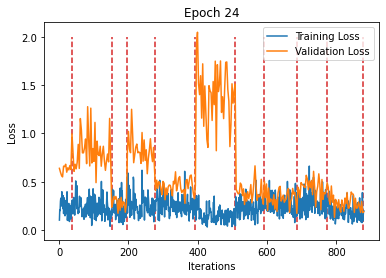

Train



Sequence:1, Seq Training Mean Loss: 0.22756062327204524, Seq Training Acc: 0.9028716216216216
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.20323910700238268, Seq Training Acc: 0.9111413043478261
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.21191868384679158, Seq Training Acc: 0.9055555555555556
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.2464002330362061, Seq Training Acc: 0.8865740740740741
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.2811474640732226, Seq Training Acc: 0.8785326086956522
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.11932069184663503, Seq Training Acc: 0.9497282608695652
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.23322425628217255, Seq Training Acc: 0.8967225609756098
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.2579321163831298, Seq Training Acc: 0.8914304123711341
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.27644939866216706, Seq Training Acc: 0.8753591954022989
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.16911530591404209, Seq Training Acc: 0.9302884615384616
******************************************************************
Epoch:25, Epoch Training Loss Mean: 0.21995869278907776, Epoch Training Acc: 0.9042212414578588
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.5698777064681053, Seq Valid Acc: 0.7369791666666666



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.7033278408803438, Seq Valid Acc: 0.647203947368421



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.2737745404243469, Seq Valid Acc: 0.8895833333333333



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.7119312617513869, Seq Valid Acc: 0.5555555555555556



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.4352982277289415, Seq Valid Acc: 0.8020833333333334



******************************************************************
Sequence:6, Seq Valid Mean Loss: 1.2824740754930597, Seq Valid Acc: 0.46463815789473684



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.4434094550432982, Seq Valid Acc: 0.8043981481481481



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.3984695555585803, Seq Valid Acc: 0.8238636363636364



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.4485219007936017, Seq Valid Acc: 0.78125



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.36481017531717524, Seq Valid Acc: 0.8244485294117647
Epoch:25, Epoch Valid Mean Loss: 0.5929336547851562, Epoch Valid Acc: 0.7202482876712328
******************************************************************


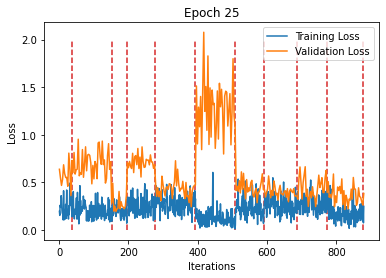

Train



Sequence:1, Seq Training Mean Loss: 0.2415383699777964, Seq Training Acc: 0.8902027027027027
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.2021510165994582, Seq Training Acc: 0.9176630434782609
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.23096174216932722, Seq Training Acc: 0.8951388888888889
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.24622097225100906, Seq Training Acc: 0.8904320987654321
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.27108733096848364, Seq Training Acc: 0.8741847826086957
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.10787153593871905, Seq Training Acc: 0.9548913043478261
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.24454451325099644, Seq Training Acc: 0.8891006097560976
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.24670706259221145, Seq Training Acc: 0.885631443298969
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.2625480147785154, Seq Training Acc: 0.8832614942528736
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.16490137435567492, Seq Training Acc: 0.93359375
******************************************************************
Epoch:26, Epoch Training Loss Mean: 0.21648791432380676, Epoch Training Acc: 0.9042924259681093
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.42755289872487384, Seq Valid Acc: 0.8333333333333334



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.6675530170139513, Seq Valid Acc: 0.6373355263157895



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.26956900556882224, Seq Valid Acc: 0.8875



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.6970705853568183, Seq Valid Acc: 0.5370370370370371



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.42845153426512694, Seq Valid Acc: 0.7980769230769231



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.7304394590227228, Seq Valid Acc: 0.48519736842105265



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.4271893324675383, Seq Valid Acc: 0.8067129629629629



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.37474510163971875, Seq Valid Acc: 0.8465909090909091



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.4519253743105921, Seq Valid Acc: 0.7780172413793104



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.2571747894672787, Seq Valid Acc: 0.8841911764705882
Epoch:26, Epoch Valid Mean Loss: 0.49170851707458496, Epoch Valid Acc: 0.7326626712328768
******************************************************************


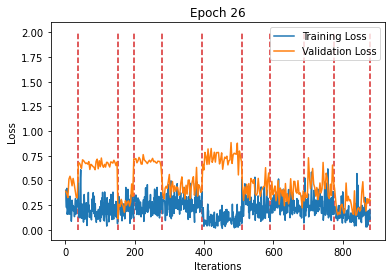

Train



Sequence:1, Seq Training Mean Loss: 0.1963686419499887, Seq Training Acc: 0.9045608108108109
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.20364178879105527, Seq Training Acc: 0.9092391304347827
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.21490576109952397, Seq Training Acc: 0.8972222222222223
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.24180851251254848, Seq Training Acc: 0.8908179012345679
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.2418888974448909, Seq Training Acc: 0.8929347826086956
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.11343829144278299, Seq Training Acc: 0.9502717391304348
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.23888098075985909, Seq Training Acc: 0.8963414634146342
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.24497296407665173, Seq Training Acc: 0.8923969072164949
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.2774576859912653, Seq Training Acc: 0.8771551724137931
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.1821751959908467, Seq Training Acc: 0.9245793269230769
******************************************************************
Epoch:27, Epoch Training Loss Mean: 0.21325737237930298, Epoch Training Acc: 0.9055381548974943
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.5241420964399973, Seq Valid Acc: 0.7682291666666666



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.6693533109991174, Seq Valid Acc: 0.6175986842105263



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.24554777046044668, Seq Valid Acc: 0.9083333333333333



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.7108134539039047, Seq Valid Acc: 0.5648148148148148



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.4374026411618942, Seq Valid Acc: 0.7956730769230769



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.9454063020254436, Seq Valid Acc: 0.4917763157894737



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.4058219183374334, Seq Valid Acc: 0.8298611111111112



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.3967436804915919, Seq Valid Acc: 0.8191287878787878



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.40809150913666037, Seq Valid Acc: 0.8114224137931034



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.24127894026391647, Seq Valid Acc: 0.8998161764705882
Epoch:27, Epoch Valid Mean Loss: 0.5194257497787476, Epoch Valid Acc: 0.7357662671232876
******************************************************************


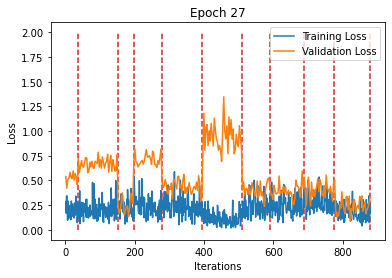

Train



Sequence:1, Seq Training Mean Loss: 0.19504434716057134, Seq Training Acc: 0.9138513513513513
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.18979973216419635, Seq Training Acc: 0.9198369565217391
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.24061356203423606, Seq Training Acc: 0.8965277777777778
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.23337924600015453, Seq Training Acc: 0.8985339506172839
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.2598247371937918, Seq Training Acc: 0.8877717391304348
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.12156543522749258, Seq Training Acc: 0.9472826086956522
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.23015388755536662, Seq Training Acc: 0.8990091463414634
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.22794325081343503, Seq Training Acc: 0.9014175257731959
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.2621208771035589, Seq Training Acc: 0.8868534482758621
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.1711215442762925, Seq Training Acc: 0.9245793269230769
******************************************************************
Epoch:28, Epoch Training Loss Mean: 0.20981672406196594, Epoch Training Acc: 0.909132972665148
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.3864799216389656, Seq Valid Acc: 0.8776041666666666



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.760750675671979, Seq Valid Acc: 0.647203947368421



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.3315965493520101, Seq Valid Acc: 0.8541666666666666



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.819466061062283, Seq Valid Acc: 0.4965277777777778



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.3900280908132211, Seq Valid Acc: 0.8092948717948718



******************************************************************
Sequence:6, Seq Valid Mean Loss: 1.5355241800609387, Seq Valid Acc: 0.5074013157894737



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.43994732587425794, Seq Valid Acc: 0.7939814814814815



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.35265286447423877, Seq Valid Acc: 0.8352272727272727



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.4555135204874236, Seq Valid Acc: 0.7801724137931034



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.21586848094182856, Seq Valid Acc: 0.9172794117647058
Epoch:28, Epoch Valid Mean Loss: 0.6105217933654785, Epoch Valid Acc: 0.7363013698630136
******************************************************************


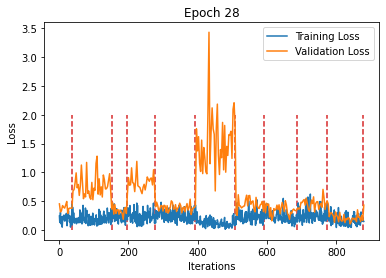

Train



Sequence:1, Seq Training Mean Loss: 0.19220258275399338, Seq Training Acc: 0.9315878378378378
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.19325740223993426, Seq Training Acc: 0.9141304347826087
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.20786739488442738, Seq Training Acc: 0.9145833333333333
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.2252132895368117, Seq Training Acc: 0.8989197530864198
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.25301251217075016, Seq Training Acc: 0.8894021739130434
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.10817027987871805, Seq Training Acc: 0.9557065217391304
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.23288879193729017, Seq Training Acc: 0.8967225609756098
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.2357984775888551, Seq Training Acc: 0.8994845360824743
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.2575939519480727, Seq Training Acc: 0.8843390804597702
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.16182701382786036, Seq Training Acc: 0.9281850961538461
******************************************************************
Epoch:29, Epoch Training Loss Mean: 0.20464514195919037, Epoch Training Acc: 0.9111617312072893
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.535256860156854, Seq Valid Acc: 0.7421875



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.6788252999908045, Seq Valid Acc: 0.5797697368421053



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.23890677293141682, Seq Valid Acc: 0.9041666666666667



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.6932105973914817, Seq Valid Acc: 0.5335648148148148



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.3912816777443274, Seq Valid Acc: 0.8125



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.6903742771399649, Seq Valid Acc: 0.5435855263157895



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.47827116317219204, Seq Valid Acc: 0.7754629629629629



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.364813152587775, Seq Valid Acc: 0.8200757575757576



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.47363092210786095, Seq Valid Acc: 0.7877155172413793



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.2969551684663576, Seq Valid Acc: 0.8740808823529411
Epoch:29, Epoch Valid Mean Loss: 0.4958797097206116, Epoch Valid Acc: 0.7253852739726028
******************************************************************


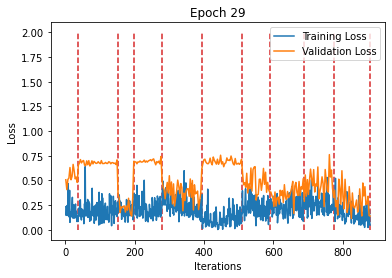

Train



Sequence:1, Seq Training Mean Loss: 0.19617529173155088, Seq Training Acc: 0.9146959459459459
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.18082215296833412, Seq Training Acc: 0.91875
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.2123877462413576, Seq Training Acc: 0.9125
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.19636920867142854, Seq Training Acc: 0.9162808641975309
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.24638334486795507, Seq Training Acc: 0.8921195652173913
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.11038564630662617, Seq Training Acc: 0.9548913043478261
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.23830606652105726, Seq Training Acc: 0.8864329268292683
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.22727377666640527, Seq Training Acc: 0.8998067010309279
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.24734858046660477, Seq Training Acc: 0.8911637931034483
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.16746047475876716, Seq Training Acc: 0.9293870192307693
******************************************************************
Epoch:30, Epoch Training Loss Mean: 0.19939258694648743, Epoch Training Acc: 0.9126921981776766
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.5724659512440363, Seq Valid Acc: 0.7109375



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.7008464806958249, Seq Valid Acc: 0.5822368421052632



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.25743778645992277, Seq Valid Acc: 0.8958333333333334



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.7218774557113647, Seq Valid Acc: 0.5300925925925926



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.41488978266716003, Seq Valid Acc: 0.8157051282051282



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.7414457115687823, Seq Valid Acc: 0.546875



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.4110538070952451, Seq Valid Acc: 0.8298611111111112



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.32567785951224243, Seq Valid Acc: 0.8579545454545454



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.43505095818947104, Seq Valid Acc: 0.7995689655172413



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.2483648543848711, Seq Valid Acc: 0.8777573529411765
Epoch:30, Epoch Valid Mean Loss: 0.4935491979122162, Epoch Valid Acc: 0.735445205479452
******************************************************************


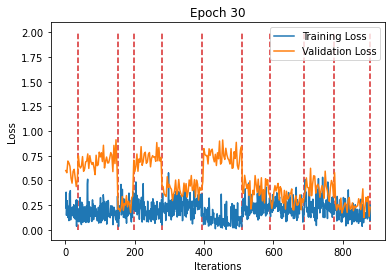

Train



Sequence:1, Seq Training Mean Loss: 0.18424366575640602, Seq Training Acc: 0.9155405405405406
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.17583973177749176, Seq Training Acc: 0.9233695652173913
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.20130449732144673, Seq Training Acc: 0.9104166666666667
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.2131192468934589, Seq Training Acc: 0.8973765432098766
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.24663986460022305, Seq Training Acc: 0.8880434782608696
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.11422616181814152, Seq Training Acc: 0.9513586956521739
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.20718371345684294, Seq Training Acc: 0.9047256097560976
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.2435492633928343, Seq Training Acc: 0.8898195876288659
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.26297048419371416, Seq Training Acc: 0.8807471264367817
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.1780821606875039, Seq Training Acc: 0.9239783653846154
******************************************************************
Epoch:31, Epoch Training Loss Mean: 0.20144858956336975, Epoch Training Acc: 0.9094177107061503
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.4619734262426694, Seq Valid Acc: 0.8125



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.6862671563499853, Seq Valid Acc: 0.5493421052631579



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.2332523951927821, Seq Valid Acc: 0.8979166666666667



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.7007600576789291, Seq Valid Acc: 0.5092592592592593



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.3039851918434485, Seq Valid Acc: 0.8766025641025641



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.6754957217919199, Seq Valid Acc: 0.5822368421052632



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.39914695642612597, Seq Valid Acc: 0.8321759259259259



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.34206908399408514, Seq Valid Acc: 0.8522727272727273



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.42103381043878096, Seq Valid Acc: 0.7984913793103449



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.2345199600300368, Seq Valid Acc: 0.9025735294117647
Epoch:31, Epoch Valid Mean Loss: 0.4582681655883789, Epoch Valid Acc: 0.7486087328767124
******************************************************************


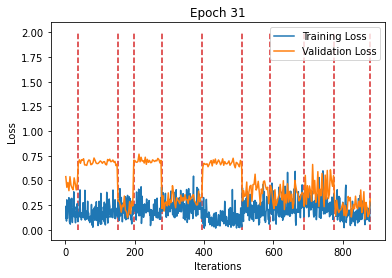

Train



Sequence:1, Seq Training Mean Loss: 0.20068757558191144, Seq Training Acc: 0.9146959459459459
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.16536472248642342, Seq Training Acc: 0.9293478260869565
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.2281056003438102, Seq Training Acc: 0.8909722222222223
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.20702755754744565, Seq Training Acc: 0.9147376543209876
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.23715649927439897, Seq Training Acc: 0.8961956521739131
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.10338580536291651, Seq Training Acc: 0.9548913043478261
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.21453978979914654, Seq Training Acc: 0.911204268292683
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.21772182172106713, Seq Training Acc: 0.9017396907216495
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.2599974558099933, Seq Training Acc: 0.8803879310344828
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.1635572493362885, Seq Training Acc: 0.9266826923076923
******************************************************************
Epoch:32, Epoch Training Loss Mean: 0.1947377473115921, Epoch Training Acc: 0.9145074031890661
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.39411310106515884, Seq Valid Acc: 0.8463541666666666



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.6816977701689068, Seq Valid Acc: 0.5838815789473685



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.27008928457895914, Seq Valid Acc: 0.89375



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.6985668893213626, Seq Valid Acc: 0.4722222222222222



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.2993501787766432, Seq Valid Acc: 0.875801282051282



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.6888135404963243, Seq Valid Acc: 0.5230263157894737



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.4293316635820601, Seq Valid Acc: 0.8113425925925926



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.33825399387966504, Seq Valid Acc: 0.8494318181818182



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.3623008995220579, Seq Valid Acc: 0.8329741379310345



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.2039635799386922, Seq Valid Acc: 0.9071691176470589
Epoch:32, Epoch Valid Mean Loss: 0.4506572484970093, Epoch Valid Acc: 0.744755993150685
******************************************************************


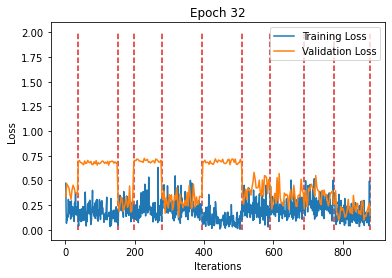

Train



Sequence:1, Seq Training Mean Loss: 0.18955715544320442, Seq Training Acc: 0.90625
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.16298660621370958, Seq Training Acc: 0.9225543478260869
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.2139909244245953, Seq Training Acc: 0.9027777777777778
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.19905570273598036, Seq Training Acc: 0.9174382716049383
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.22595284529354262, Seq Training Acc: 0.8951086956521739
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.1051193009171149, Seq Training Acc: 0.9532608695652174
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.20995098634100542, Seq Training Acc: 0.9043445121951219
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.22835998179525444, Seq Training Acc: 0.8994845360824743
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.24269719134973383, Seq Training Acc: 0.8890086206896551
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.14969191044712296, Seq Training Acc: 0.9296875
******************************************************************
Epoch:33, Epoch Training Loss Mean: 0.18864805996418, Epoch Training Acc: 0.9140802961275627
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.43909572313229245, Seq Valid Acc: 0.8255208333333334



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.6831333449012355, Seq Valid Acc: 0.5674342105263158



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.2249191552400589, Seq Valid Acc: 0.9125



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.6991073930705035, Seq Valid Acc: 0.5046296296296297



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.35399348384294754, Seq Valid Acc: 0.8349358974358975



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.7286990488830366, Seq Valid Acc: 0.4925986842105263



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.37736774649884963, Seq Valid Acc: 0.8391203703703703



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.34329424346938275, Seq Valid Acc: 0.8380681818181818



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.44284890437948293, Seq Valid Acc: 0.7920258620689655



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.18599010412307346, Seq Valid Acc: 0.9227941176470589
Epoch:33, Epoch Valid Mean Loss: 0.4645826816558838, Epoch Valid Acc: 0.7353381849315068
******************************************************************


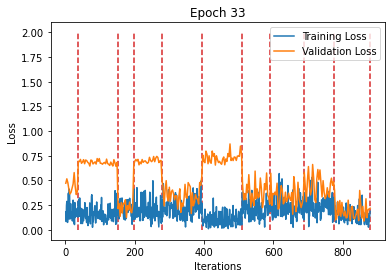

Train



Sequence:1, Seq Training Mean Loss: 0.17696695402264595, Seq Training Acc: 0.9256756756756757
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.17082345339915025, Seq Training Acc: 0.9274456521739131
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.1905163273215294, Seq Training Acc: 0.9194444444444444
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.20752957233308275, Seq Training Acc: 0.9070216049382716
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.22361520062322202, Seq Training Acc: 0.8991847826086956
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.10157079327365627, Seq Training Acc: 0.9573369565217391
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.20149115704726883, Seq Training Acc: 0.9115853658536586
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.22272336782561136, Seq Training Acc: 0.8985180412371134
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.2577348330068862, Seq Training Acc: 0.8836206896551724
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.1428332641864052, Seq Training Acc: 0.9408052884615384
******************************************************************
Epoch:34, Epoch Training Loss Mean: 0.18721644580364227, Epoch Training Acc: 0.9178530751708428
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.3375346052149932, Seq Valid Acc: 0.8645833333333334



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.6825168101411117, Seq Valid Acc: 0.5912828947368421



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.27021065453688303, Seq Valid Acc: 0.8854166666666666



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.6955532961421542, Seq Valid Acc: 0.5046296296296297



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.2962092222311558, Seq Valid Acc: 0.8733974358974359



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.6950739826026716, Seq Valid Acc: 0.506578947368421



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.39462104715682844, Seq Valid Acc: 0.8310185185185185



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.3320329053835435, Seq Valid Acc: 0.8693181818181818



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.3845347710724535, Seq Valid Acc: 0.822198275862069



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.21313976584111943, Seq Valid Acc: 0.9117647058823529
Epoch:34, Epoch Valid Mean Loss: 0.4479254484176636, Epoch Valid Acc: 0.7501070205479452
******************************************************************


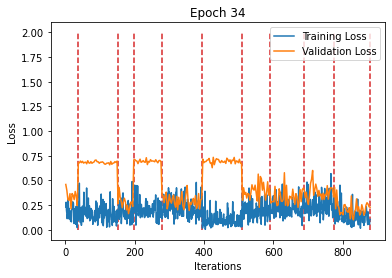

Train



Sequence:1, Seq Training Mean Loss: 0.20958803261856776, Seq Training Acc: 0.9054054054054054
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.16539185876431672, Seq Training Acc: 0.9271739130434783
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.18383221858077578, Seq Training Acc: 0.9236111111111112
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.18258297250226693, Seq Training Acc: 0.9162808641975309
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.20646689783619798, Seq Training Acc: 0.9103260869565217
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.09198700842326102, Seq Training Acc: 0.9605978260869565
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.1805113112417663, Seq Training Acc: 0.9199695121951219
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.19654306838500132, Seq Training Acc: 0.9120489690721649
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.22816007806994448, Seq Training Acc: 0.8940373563218391
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.13430733335777545, Seq Training Acc: 0.9459134615384616
******************************************************************
Epoch:35, Epoch Training Loss Mean: 0.1729421317577362, Epoch Training Acc: 0.9238325740318907
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.45884308218955994, Seq Valid Acc: 0.8151041666666666



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.6567760188328592, Seq Valid Acc: 0.6069078947368421



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.23995814621448516, Seq Valid Acc: 0.89375



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.7089531178827639, Seq Valid Acc: 0.4965277777777778



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.29047317764697933, Seq Valid Acc: 0.8629807692307693



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.7657950896965829, Seq Valid Acc: 0.5049342105263158



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.43402099167859115, Seq Valid Acc: 0.7986111111111112



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.34426549754359503, Seq Valid Acc: 0.8551136363636364



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.3784490104379325, Seq Valid Acc: 0.8211206896551724



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.2828095487373717, Seq Valid Acc: 0.8731617647058824
Epoch:35, Epoch Valid Mean Loss: 0.47021663188934326, Epoch Valid Acc: 0.7389768835616438
******************************************************************


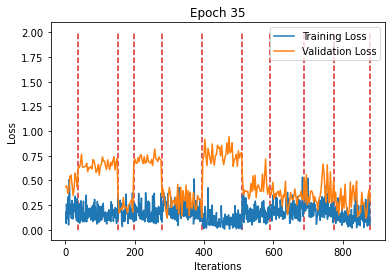

Train



Sequence:1, Seq Training Mean Loss: 0.1732154192553984, Seq Training Acc: 0.9256756756756757
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.16931766362293907, Seq Training Acc: 0.9263586956521739
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.20955127825339634, Seq Training Acc: 0.9034722222222222
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.18153030113719495, Seq Training Acc: 0.9243827160493827
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.2168830935721812, Seq Training Acc: 0.9057065217391305
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.09945718115600555, Seq Training Acc: 0.95625
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.18577345397050787, Seq Training Acc: 0.9195884146341463
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.19839382878283865, Seq Training Acc: 0.915270618556701
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.21134918722613105, Seq Training Acc: 0.9087643678160919
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.13597804915088302, Seq Training Acc: 0.9396033653846154
******************************************************************
Epoch:36, Epoch Training Loss Mean: 0.17471539974212646, Epoch Training Acc: 0.9241529043280182
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.3702581152319908, Seq Valid Acc: 0.84375



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.6667400943605524, Seq Valid Acc: 0.6085526315789473



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.2646065135796865, Seq Valid Acc: 0.9041666666666667



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.6944375016071178, Seq Valid Acc: 0.5277777777777778



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.31291282902925444, Seq Valid Acc: 0.8661858974358975



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.6899989717885068, Seq Valid Acc: 0.5115131578947368



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.3762056799950423, Seq Valid Acc: 0.8449074074074074



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.33541367225574725, Seq Valid Acc: 0.8494318181818182



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.379345310145411, Seq Valid Acc: 0.8275862068965517



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.23756861883927793, Seq Valid Acc: 0.8915441176470589
Epoch:36, Epoch Valid Mean Loss: 0.44940492510795593, Epoch Valid Acc: 0.7514982876712328
******************************************************************


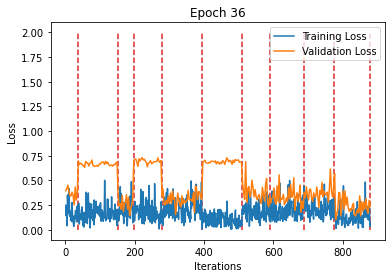

Train



Sequence:1, Seq Training Mean Loss: 0.14883454939400828, Seq Training Acc: 0.9366554054054054
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.14335748622922795, Seq Training Acc: 0.938858695652174
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.19449471773372756, Seq Training Acc: 0.9125
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.16319980633295614, Seq Training Acc: 0.9313271604938271
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.20511287606280784, Seq Training Acc: 0.9125
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.087363829205582, Seq Training Acc: 0.9586956521739131
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.18965648768878565, Seq Training Acc: 0.915015243902439
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.20400567679214723, Seq Training Acc: 0.9104381443298969
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.21045788154862394, Seq Training Acc: 0.9123563218390804
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.12471777927846862, Seq Training Acc: 0.9477163461538461
******************************************************************
Epoch:37, Epoch Training Loss Mean: 0.16425982117652893, Epoch Training Acc: 0.9289222665148064
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.4608381415406863, Seq Valid Acc: 0.7942708333333334



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.6613567596987674, Seq Valid Acc: 0.6282894736842105



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.23879961868127186, Seq Valid Acc: 0.8875



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.6998813615904914, Seq Valid Acc: 0.5069444444444444



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.32123827322935444, Seq Valid Acc: 0.8613782051282052



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.7004061027577049, Seq Valid Acc: 0.515625



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.4052158522385138, Seq Valid Acc: 0.8113425925925926



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.32889839645588037, Seq Valid Acc: 0.8522727272727273



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.34841072507973375, Seq Valid Acc: 0.8545258620689655



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.24011857961030567, Seq Valid Acc: 0.8887867647058824
Epoch:37, Epoch Valid Mean Loss: 0.45324164628982544, Epoch Valid Acc: 0.7487157534246576
******************************************************************


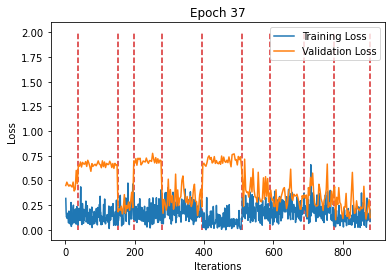

Train



Sequence:1, Seq Training Mean Loss: 0.16313250841119806, Seq Training Acc: 0.9358108108108109
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.1433662951964399, Seq Training Acc: 0.9334239130434783
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.1841327589419153, Seq Training Acc: 0.9166666666666666
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.18352773695908212, Seq Training Acc: 0.9205246913580247
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.21161135033420894, Seq Training Acc: 0.9027173913043478
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.08368433566116121, Seq Training Acc: 0.9630434782608696
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.18722961584060657, Seq Training Acc: 0.9153963414634146
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.1993935872061351, Seq Training Acc: 0.9114046391752577
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.20025762671540523, Seq Training Acc: 0.9116379310344828
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.1284768225517697, Seq Training Acc: 0.9432091346153846
******************************************************************
Epoch:38, Epoch Training Loss Mean: 0.16527535021305084, Epoch Training Acc: 0.9262172551252847
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.44424109905958176, Seq Valid Acc: 0.8125



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.6611022776678989, Seq Valid Acc: 0.6439144736842105



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.29222752451896666, Seq Valid Acc: 0.8791666666666667



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.6972108218404982, Seq Valid Acc: 0.5057870370370371



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.2946571818529031, Seq Valid Acc: 0.8653846153846154



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.775957863581808, Seq Valid Acc: 0.5032894736842105



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.3617968470961959, Seq Valid Acc: 0.8391203703703703



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.3496085089264494, Seq Valid Acc: 0.8428030303030303



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.40188154475442295, Seq Valid Acc: 0.8168103448275862



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.1928856147124487, Seq Valid Acc: 0.9181985294117647
Epoch:38, Epoch Valid Mean Loss: 0.45944246649742126, Epoch Valid Acc: 0.751070205479452
******************************************************************


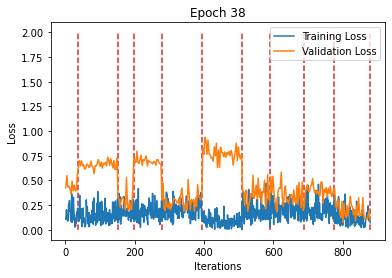

Train



Sequence:1, Seq Training Mean Loss: 0.17878647339907852, Seq Training Acc: 0.9282094594594594
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.14653208663930065, Seq Training Acc: 0.9328804347826087
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.17282352935936715, Seq Training Acc: 0.9284722222222223
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.17064590379595757, Seq Training Acc: 0.9247685185185185
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.18487596741837004, Seq Training Acc: 0.9201086956521739
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.08152674492954722, Seq Training Acc: 0.9630434782608696
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.182525355414283, Seq Training Acc: 0.9134908536585366
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.17773630397067858, Seq Training Acc: 0.9233247422680413
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.22317406492329192, Seq Training Acc: 0.9012212643678161
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.12240264728629532, Seq Training Acc: 0.9501201923076923
******************************************************************
Epoch:39, Epoch Training Loss Mean: 0.15951652824878693, Epoch Training Acc: 0.9300256264236902
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.4274054194490115, Seq Valid Acc: 0.8203125



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.6804139112171373, Seq Valid Acc: 0.5830592105263158



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.19703029642502468, Seq Valid Acc: 0.9125



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.7024404031259043, Seq Valid Acc: 0.47800925925925924



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.2548843530508188, Seq Valid Acc: 0.8894230769230769



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.70021453970357, Seq Valid Acc: 0.5



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.3481496782214553, Seq Valid Acc: 0.8472222222222222



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.333059545267712, Seq Valid Acc: 0.8361742424242424



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.32254888014546756, Seq Valid Acc: 0.8631465517241379



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.24466335379025517, Seq Valid Acc: 0.8952205882352942
Epoch:39, Epoch Valid Mean Loss: 0.43670564889907837, Epoch Valid Acc: 0.7473244863013698
******************************************************************


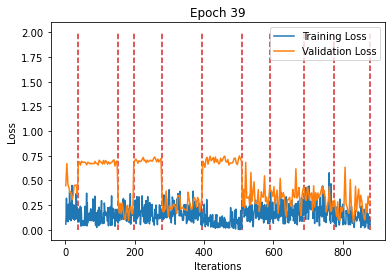

Train



Sequence:1, Seq Training Mean Loss: 0.16859236188434265, Seq Training Acc: 0.9180743243243243
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.1435806872566109, Seq Training Acc: 0.9375
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.19170377237929237, Seq Training Acc: 0.9125
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.17752074606624652, Seq Training Acc: 0.9201388888888888
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.18863093645676324, Seq Training Acc: 0.9214673913043478
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.07390187964369746, Seq Training Acc: 0.9709239130434782
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.17889791495371155, Seq Training Acc: 0.9249237804878049
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.1877878964638587, Seq Training Acc: 0.9236469072164949
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.20514203162713981, Seq Training Acc: 0.9170258620689655
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.12706316887544325, Seq Training Acc: 0.9456129807692307
******************************************************************
Epoch:40, Epoch Training Loss Mean: 0.15933234989643097, Epoch Training Acc: 0.9323035307517085
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.38177592555681866, Seq Valid Acc: 0.8567708333333334



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.6732997611949318, Seq Valid Acc: 0.5912828947368421



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.2240526388088862, Seq Valid Acc: 0.9145833333333333



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.7001057863235474, Seq Valid Acc: 0.5196759259259259



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.29731250802675885, Seq Valid Acc: 0.8645833333333334



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.7169192700009597, Seq Valid Acc: 0.4876644736842105



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.309490489187064, Seq Valid Acc: 0.8761574074074074



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.32253850003083545, Seq Valid Acc: 0.84375



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.39564242393806065, Seq Valid Acc: 0.8135775862068966



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.1895421142963802, Seq Valid Acc: 0.921875
Epoch:40, Epoch Valid Mean Loss: 0.43899503350257874, Epoch Valid Acc: 0.7506421232876712
******************************************************************


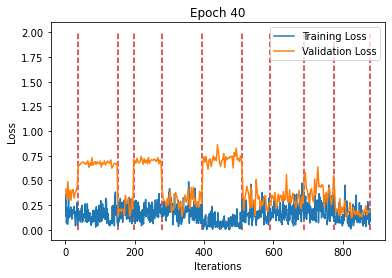

Train



Sequence:1, Seq Training Mean Loss: 0.17396871876474973, Seq Training Acc: 0.9239864864864865
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.14245657878725426, Seq Training Acc: 0.9396739130434782
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.1599858705368307, Seq Training Acc: 0.925
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.15416726798830946, Seq Training Acc: 0.935570987654321
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.1831494405541731, Seq Training Acc: 0.9146739130434782
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.0790923168801743, Seq Training Acc: 0.9660326086956522
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.1737550590641615, Seq Training Acc: 0.9283536585365854
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.18911330325087322, Seq Training Acc: 0.9162371134020618
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.2036251610723035, Seq Training Acc: 0.9080459770114943
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.12293416824048528, Seq Training Acc: 0.9462139423076923
******************************************************************
Epoch:41, Epoch Training Loss Mean: 0.15462017059326172, Epoch Training Acc: 0.9320543849658315
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.34581949437657994, Seq Valid Acc: 0.875



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.6718396607198214, Seq Valid Acc: 0.6241776315789473



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.1992844079931577, Seq Valid Acc: 0.925



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.6960568405963756, Seq Valid Acc: 0.48032407407407407



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.27682950672430867, Seq Valid Acc: 0.874198717948718



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.7283673866799003, Seq Valid Acc: 0.49917763157894735



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.3209335224495994, Seq Valid Acc: 0.8726851851851852



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.30252970800255286, Seq Valid Acc: 0.8674242424242424



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.3558193029000841, Seq Valid Acc: 0.84375



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.1605421821860706, Seq Valid Acc: 0.9356617647058824
Epoch:41, Epoch Valid Mean Loss: 0.42589977383613586, Epoch Valid Acc: 0.7623073630136986
******************************************************************


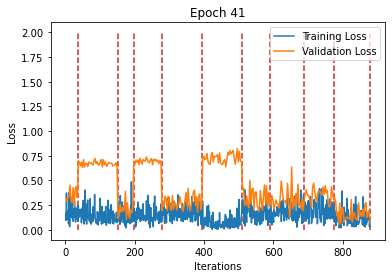

Train



Sequence:1, Seq Training Mean Loss: 0.17324499564396367, Seq Training Acc: 0.9273648648648649
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.13648084146173103, Seq Training Acc: 0.9396739130434782
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.17792951025896603, Seq Training Acc: 0.9166666666666666
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.15581982854155846, Seq Training Acc: 0.9282407407407407
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.18863558623453844, Seq Training Acc: 0.91875
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.07833341884872187, Seq Training Acc: 0.9660326086956522
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.15489775467118838, Seq Training Acc: 0.930640243902439
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.18995904526913288, Seq Training Acc: 0.916881443298969
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.1998972037657239, Seq Training Acc: 0.9051724137931034
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.10631230590829197, Seq Training Acc: 0.9555288461538461
******************************************************************
Epoch:42, Epoch Training Loss Mean: 0.15149226784706116, Epoch Training Acc: 0.9327306378132119
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.3495880092183749, Seq Valid Acc: 0.8463541666666666



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.6788479717154252, Seq Valid Acc: 0.6019736842105263



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.21114943375190098, Seq Valid Acc: 0.9041666666666667



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.7049475930355213, Seq Valid Acc: 0.5428240740740741



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.2934395220035162, Seq Valid Acc: 0.8645833333333334



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.8939152532502225, Seq Valid Acc: 0.4712171052631579



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.31756906928839507, Seq Valid Acc: 0.8703703703703703



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.32662569212191034, Seq Valid Acc: 0.8522727272727273



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.35899530916378414, Seq Valid Acc: 0.8426724137931034



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.1819194408462328, Seq Valid Acc: 0.9200367647058824
Epoch:42, Epoch Valid Mean Loss: 0.45737728476524353, Epoch Valid Acc: 0.754173801369863
******************************************************************


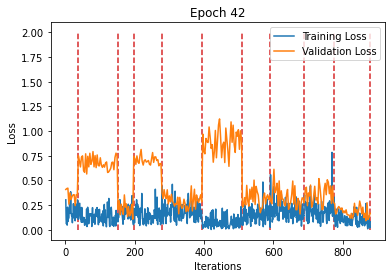

Train



Sequence:1, Seq Training Mean Loss: 0.14846250384643273, Seq Training Acc: 0.9349662162162162
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.13393150367166684, Seq Training Acc: 0.9402173913043478
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.15811964770158132, Seq Training Acc: 0.9256944444444445
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.15517096092671523, Seq Training Acc: 0.9305555555555556
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.18268715366721153, Seq Training Acc: 0.9192934782608696
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.08453313362602469, Seq Training Acc: 0.9608695652173913
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.1692572407333589, Seq Training Acc: 0.930640243902439
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.16734682553514993, Seq Training Acc: 0.9265463917525774
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.18681436113413724, Seq Training Acc: 0.9173850574712644
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.11646971434283142, Seq Training Acc: 0.9459134615384616
******************************************************************
Epoch:43, Epoch Training Loss Mean: 0.14782144129276276, Epoch Training Acc: 0.9343322892938497
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.3715677683552106, Seq Valid Acc: 0.8515625



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.6742929973100361, Seq Valid Acc: 0.5814144736842105



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.20920081833998364, Seq Valid Acc: 0.9166666666666666



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.6963307967892399, Seq Valid Acc: 0.5243055555555556



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.2614271694268936, Seq Valid Acc: 0.8790064102564102



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.7336223596020749, Seq Valid Acc: 0.4967105263157895



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.257242935123267, Seq Valid Acc: 0.8912037037037037



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.2942269385764093, Seq Valid Acc: 0.8617424242424242



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.335235393252866, Seq Valid Acc: 0.8405172413793104



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.19933238691266844, Seq Valid Acc: 0.9117647058823529
Epoch:43, Epoch Valid Mean Loss: 0.4220834970474243, Epoch Valid Acc: 0.7577054794520548
******************************************************************


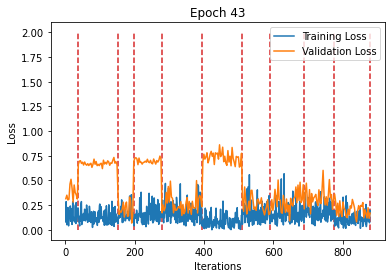

Train



Sequence:1, Seq Training Mean Loss: 0.1171817865122009, Seq Training Acc: 0.9552364864864865
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.1427035890519619, Seq Training Acc: 0.933695652173913
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.15760120906763606, Seq Training Acc: 0.9256944444444445
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.14749865773145432, Seq Training Acc: 0.935570987654321
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.15966303243261318, Seq Training Acc: 0.9258152173913043
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.07679088168737033, Seq Training Acc: 0.9665760869565218
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.1753319962086474, Seq Training Acc: 0.9233993902439024
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.18026605494243583, Seq Training Acc: 0.9155927835051546
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.1715036427666401, Seq Training Acc: 0.9281609195402298
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.10261259210081054, Seq Training Acc: 0.9576322115384616
******************************************************************
Epoch:44, Epoch Training Loss Mean: 0.14172419905662537, Epoch Training Acc: 0.9369661161731208
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.4387279376387596, Seq Valid Acc: 0.7942708333333334



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.6803232949031027, Seq Valid Acc: 0.5773026315789473



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.20371283292770387, Seq Valid Acc: 0.9229166666666667



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.6965803768899705, Seq Valid Acc: 0.4965277777777778



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.24520486096541086, Seq Valid Acc: 0.8918269230769231



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.6955136343052513, Seq Valid Acc: 0.5139802631578947



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.33970195220576394, Seq Valid Acc: 0.8449074074074074



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.2678415725628535, Seq Valid Acc: 0.8920454545454546



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.35472033866520586, Seq Valid Acc: 0.8351293103448276



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.21550609083736644, Seq Valid Acc: 0.9053308823529411
Epoch:44, Epoch Valid Mean Loss: 0.426704466342926, Epoch Valid Acc: 0.7543878424657534
******************************************************************


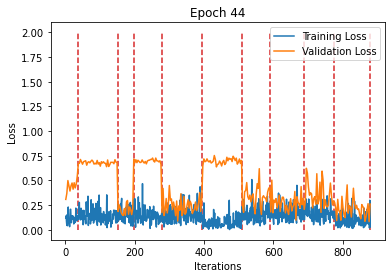

Train



Sequence:1, Seq Training Mean Loss: 0.14108046154315407, Seq Training Acc: 0.9391891891891891
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.13061106956523397, Seq Training Acc: 0.9440217391304347
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.1617841474711895, Seq Training Acc: 0.9305555555555556
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.150753947549764, Seq Training Acc: 0.9351851851851852
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.168092873789694, Seq Training Acc: 0.9282608695652174
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.08021485345519107, Seq Training Acc: 0.9627717391304348
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.16390483090426863, Seq Training Acc: 0.9256859756097561
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.1644816378649977, Seq Training Acc: 0.926868556701031
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.18141844787303057, Seq Training Acc: 0.9170258620689655
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.10561666206026879, Seq Training Acc: 0.9528245192307693
******************************************************************
Epoch:45, Epoch Training Loss Mean: 0.14174196124076843, Epoch Training Acc: 0.9374644077448747
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.37830548236767453, Seq Valid Acc: 0.8333333333333334



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.6756331434375361, Seq Valid Acc: 0.6044407894736842



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.2056318034728368, Seq Valid Acc: 0.9229166666666667



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.6958388200512639, Seq Valid Acc: 0.5034722222222222



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.26587004233629274, Seq Valid Acc: 0.8798076923076923



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.7187171421552959, Seq Valid Acc: 0.4810855263157895



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.2959576889320656, Seq Valid Acc: 0.8738425925925926



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.2963265419909448, Seq Valid Acc: 0.8683712121212122



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.30410952840385763, Seq Valid Acc: 0.8620689655172413



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.22838149855242057, Seq Valid Acc: 0.9053308823529411
Epoch:45, Epoch Valid Mean Loss: 0.42506784200668335, Epoch Valid Acc: 0.7569563356164384
******************************************************************


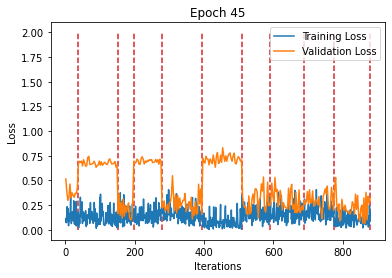

Train



Sequence:1, Seq Training Mean Loss: 0.13337786848077904, Seq Training Acc: 0.9493243243243243
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.11959074470012085, Seq Training Acc: 0.9505434782608696
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.16792466665307682, Seq Training Acc: 0.9222222222222223
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.14177058547459268, Seq Training Acc: 0.9320987654320988
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.17355282206250275, Seq Training Acc: 0.9236413043478261
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.06956578274257481, Seq Training Acc: 0.970108695652174
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.16051779087723755, Seq Training Acc: 0.9298780487804879
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.15936097929004542, Seq Training Acc: 0.9320231958762887
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.16734250913234963, Seq Training Acc: 0.9224137931034483
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.11022808390687434, Seq Training Acc: 0.9537259615384616
******************************************************************
Epoch:46, Epoch Training Loss Mean: 0.1370496302843094, Epoch Training Acc: 0.9399914578587699
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.37919506182273227, Seq Valid Acc: 0.8489583333333334



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.6810205029813867, Seq Valid Acc: 0.578125



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.18928402960300444, Seq Valid Acc: 0.91875



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.6997129144491973, Seq Valid Acc: 0.4930555555555556



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.2624748918490532, Seq Valid Acc: 0.8846153846153846



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.6916495404745403, Seq Valid Acc: 0.5337171052631579



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.293926023222782, Seq Valid Acc: 0.8819444444444444



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.26934092785372876, Seq Valid Acc: 0.8787878787878788



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.32269803408918707, Seq Valid Acc: 0.8545258620689655



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.19590122822452993, Seq Valid Acc: 0.9044117647058824
Epoch:46, Epoch Valid Mean Loss: 0.4161745607852936, Epoch Valid Acc: 0.7615582191780822
******************************************************************


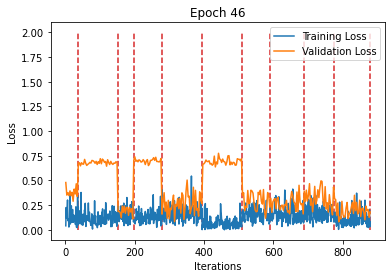

Train



Sequence:1, Seq Training Mean Loss: 0.1331534566911491, Seq Training Acc: 0.9391891891891891
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.12982901171173739, Seq Training Acc: 0.9442934782608695
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.15023305411967966, Seq Training Acc: 0.9375
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.1470290848778354, Seq Training Acc: 0.9359567901234568
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.1803254244444163, Seq Training Acc: 0.9203804347826087
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.07078247049256511, Seq Training Acc: 0.9709239130434782
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.17780795875119, Seq Training Acc: 0.9214939024390244
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.1686362200176593, Seq Training Acc: 0.9259020618556701
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.17770587160498247, Seq Training Acc: 0.9170258620689655
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.11748202414198133, Seq Training Acc: 0.9477163461538461
******************************************************************
Epoch:47, Epoch Training Loss Mean: 0.14353163540363312, Epoch Training Acc: 0.9368593394077449
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.39866497615973157, Seq Valid Acc: 0.8255208333333334



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.6837620060694846, Seq Valid Acc: 0.5723684210526315



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.17203482786814372, Seq Valid Acc: 0.9145833333333333



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.7001455823580424, Seq Valid Acc: 0.4965277777777778



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.22769081172270653, Seq Valid Acc: 0.8974358974358975



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.6951483770420677, Seq Valid Acc: 0.5287828947368421



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.30278249360896925, Seq Valid Acc: 0.8622685185185185



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.27740076568090555, Seq Valid Acc: 0.8664772727272727



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.3448815268689188, Seq Valid Acc: 0.8480603448275862



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.22042451316819472, Seq Valid Acc: 0.8988970588235294
Epoch:47, Epoch Valid Mean Loss: 0.41908326745033264, Epoch Valid Acc: 0.7565282534246576
******************************************************************


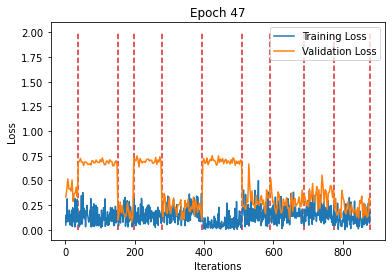

Train



Sequence:1, Seq Training Mean Loss: 0.1444146724770198, Seq Training Acc: 0.9315878378378378
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.13550456603584082, Seq Training Acc: 0.939945652173913
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.16252483518587219, Seq Training Acc: 0.9256944444444445
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.1306429900182986, Seq Training Acc: 0.9402006172839507
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.16944318925556928, Seq Training Acc: 0.9214673913043478
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.07505045764947958, Seq Training Acc: 0.9665760869565218
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.1439143876295264, Seq Training Acc: 0.9359756097560976
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.16220650868010275, Seq Training Acc: 0.9291237113402062
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.18275368050939736, Seq Training Acc: 0.9166666666666666
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.10662782452821445, Seq Training Acc: 0.9555288461538461
******************************************************************
Epoch:48, Epoch Training Loss Mean: 0.13834021985530853, Epoch Training Acc: 0.9379271070615034
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.47259868184725445, Seq Valid Acc: 0.7760416666666666



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.6850211102711526, Seq Valid Acc: 0.5485197368421053



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.21935101250807446, Seq Valid Acc: 0.9083333333333333



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.7029250904365822, Seq Valid Acc: 0.49537037037037035



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.255683717246239, Seq Valid Acc: 0.8926282051282052



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.697825794157229, Seq Valid Acc: 0.4868421052631579



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.2867292058136728, Seq Valid Acc: 0.8877314814814815



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.2375898939190489, Seq Valid Acc: 0.8920454545454546



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.32391543557931635, Seq Valid Acc: 0.8631465517241379



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.22285326197743416, Seq Valid Acc: 0.9053308823529411
Epoch:48, Epoch Valid Mean Loss: 0.42127734422683716, Epoch Valid Acc: 0.7523544520547946
******************************************************************


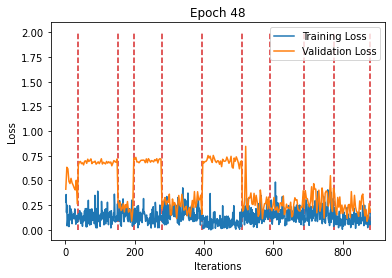

Train



Sequence:1, Seq Training Mean Loss: 0.13801748436447736, Seq Training Acc: 0.9324324324324325
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.134498336052765, Seq Training Acc: 0.9383152173913043
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.15625182911753654, Seq Training Acc: 0.9236111111111112
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.1346795499600746, Seq Training Acc: 0.9402006172839507
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.15804214036982991, Seq Training Acc: 0.9323369565217391
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.08023643556010464, Seq Training Acc: 0.964945652173913
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.14556286577135324, Seq Training Acc: 0.9371189024390244
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.16098214624468812, Seq Training Acc: 0.930090206185567
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.17879885666329284, Seq Training Acc: 0.9227729885057471
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.1062105343130847, Seq Training Acc: 0.9537259615384616
******************************************************************
Epoch:49, Epoch Training Loss Mean: 0.13675305247306824, Epoch Training Acc: 0.9394575740318907
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.4070981939633687, Seq Valid Acc: 0.828125



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.6791312992572784, Seq Valid Acc: 0.5657894736842105



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.2058548480272293, Seq Valid Acc: 0.9145833333333333



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.7123742567168342, Seq Valid Acc: 0.46296296296296297



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.2501656030997252, Seq Valid Acc: 0.8918269230769231



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.6943481831174148, Seq Valid Acc: 0.5361842105263158



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.27832104320879336, Seq Valid Acc: 0.8784722222222222



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.3002838898788799, Seq Valid Acc: 0.8683712121212122



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.3245451758647787, Seq Valid Acc: 0.8556034482758621



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.22165311412776217, Seq Valid Acc: 0.9108455882352942
Epoch:49, Epoch Valid Mean Loss: 0.423040509223938, Epoch Valid Acc: 0.756742294520548
******************************************************************


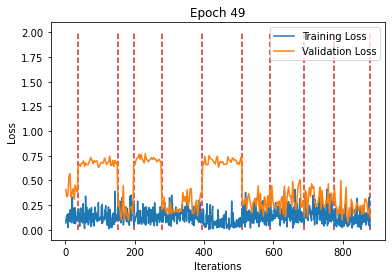

Train



Sequence:1, Seq Training Mean Loss: 0.16614937550715497, Seq Training Acc: 0.9273648648648649
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.12009405176276745, Seq Training Acc: 0.9486413043478261
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.16431972401009665, Seq Training Acc: 0.9243055555555556
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.1508694735850081, Seq Training Acc: 0.9351851851851852
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.1716805281198543, Seq Training Acc: 0.9255434782608696
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.06486657794929393, Seq Training Acc: 0.971195652173913
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.15798209412250577, Seq Training Acc: 0.9298780487804879
******************************************************************



Sequence:8, Seq Training Mean Loss: 0.16225369831489533, Seq Training Acc: 0.9275128865979382
******************************************************************



Sequence:9, Seq Training Mean Loss: 0.18451015250864386, Seq Training Acc: 0.9155890804597702
******************************************************************



Sequence:10, Seq Training Mean Loss: 0.10275295596175756, Seq Training Acc: 0.9600360576923077
******************************************************************
Epoch:50, Epoch Training Loss Mean: 0.1391889601945877, Epoch Training Acc: 0.9391728359908884
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.3855806961655617, Seq Valid Acc: 0.8411458333333334



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.6867692423494238, Seq Valid Acc: 0.5575657894736842



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.15550306538740793, Seq Valid Acc: 0.9333333333333333



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.6962158260522066, Seq Valid Acc: 0.5034722222222222



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.2734328107191966, Seq Valid Acc: 0.875



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.6883536561539298, Seq Valid Acc: 0.5180921052631579



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.25524689146765955, Seq Valid Acc: 0.8877314814814815



******************************************************************
Sequence:8, Seq Valid Mean Loss: 0.2605096860365434, Seq Valid Acc: 0.8882575757575758



******************************************************************
Sequence:9, Seq Valid Mean Loss: 0.3094258935287081, Seq Valid Acc: 0.8577586206896551



******************************************************************
Sequence:10, Seq Valid Mean Loss: 0.2094516721280182, Seq Valid Acc: 0.9163602941176471
Epoch:50, Epoch Valid Mean Loss: 0.41184622049331665, Epoch Valid Acc: 0.7602739726027398
******************************************************************


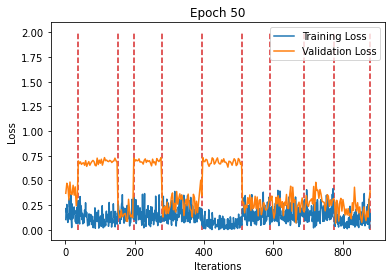


Save Model
Finished Training


In [40]:
if run_train:
    writer = SummaryWriter('runs/008_Run_Optunav2_alldata')
    max_iter_per_seq = 115
    # 训练迭代总步数
    num_train_iter_per_epoch = 0
    num_train_iterations = [] # For plot parting line
    num_train_iterations_per_dl = [max_iter_per_seq if len(dl)>= max_iter_per_seq else len(dl) for dl in train_dls]
    for seq_dataloaders in dataloaders:
        if len(seq_dataloaders[train_dl_idx]) <= max_iter_per_seq:
            num_train_iter_per_epoch += len(seq_dataloaders[train_dl_idx])
        else:
            num_train_iter_per_epoch += max_iter_per_seq
        num_train_iterations.append(num_train_iter_per_epoch)
    print("Total Train Iterations: ",num_train_iter_per_epoch)
    print("Total Train Iterations List: ",num_train_iterations)
        
    # 训练迭代总步数为验证迭代总步数的3倍
    num_val_iterations = [int(number / 3) for number in num_train_iterations]
    num_val_iter_per_epoch = num_val_iterations[-1]
    
    # iterations in every seq
    num_val_iter_per_seq = []
    num_val_iter_per_seq.append(num_val_iterations[0])
    for i in range(len(num_val_iterations)-1):
        diff = num_val_iterations[i+1] - num_val_iterations[i] # The latter minus the former
        num_val_iter_per_seq.append(diff)
        
    print("Valid iterations per seq: ",num_val_iter_per_seq)
        
    optimizer = torch.optim.Adam(model.parameters(),lr=lr,eps=1e-08)

    scheduler = OneCycleLR(optimizer, num_train_iter_per_epoch, num_epochs, min_lr_factor=min_lr_factor)
    scheduler.step(epoch=0)
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.
    loss_min = 0.
    
    for epoch in tqdm(range(1,num_epochs+1)):

        print('Train')

        model.train()
        
        running_corrects = 0

        train_loss_array = np.zeros(num_train_iter_per_epoch, dtype=np.single)

        # mse_y = torch.zeros(batch_sizes[0]//2).to(device)
        
        i = 0
        seq_idx = 1
        for (refs, train_dl, max_num) in zip(refs_list, train_dls, num_train_iterations_per_dl):
            # obtain the refs in every seq
            
            curr_train_dl = train_dl

            curr_refs = refs.float().to(device)

            # Training
            dl_iter = iter(curr_train_dl)
            
            # This two only used to compute the loss and acc in every Sequence
            running_loss = 0
            corrects = 0
            for idx in tqdm(range(max_num)):
                if idx >= max_iter_per_seq:
                    break
                try:
                    img1, img2, targets = next(dl_iter)

                except (StopIteration, TypeError):
                    dl_iter = iter(curr_train_dl)
                    img1, img2, targets = next(dl_iter)
                
                scheduler.zero_grad()

                img1 = img1.float().to(device)
                img2 = img2.float().to(device)
                targets = targets.view(-1)
                targets = targets.float().to(device)

                # forward pass
                loss, preds = model.compute_loss(img1, img2, curr_refs, targets)
                
                loss.backward()
                
                running_loss += loss.item()
                corrects += torch.sum(preds == targets)
                running_corrects += torch.sum(preds == targets)

                train_loss_array[i] = loss.cpu().detach().numpy()
               
                
                # record loss and accuracy per iteration
                c = torch.sum(preds == targets)
                acc = int(c) / img1.size(0)
                writer.add_scalar('Train/Loss per Iteration',train_loss_array[i], ((epoch - 1) * num_train_iter_per_epoch)+ i)
                writer.add_scalar('Train/Acc per Iteration',acc, ((epoch - 1) * num_train_iter_per_epoch)+ i)
                
                # Record the lr
                curr_lr = get_lr(optimizer)
                writer.add_scalar('Train/Learning Rate',curr_lr , ((epoch - 1) * num_train_iter_per_epoch)+ i)
                
                i += 1
                scheduler.step()
            
            # record loss and accuracy in every train dataloader (namely every Sequence)
            #seq_train_mean_loss = running_loss / len(curr_train_dl)
            #seq_train_acc = int(corrects) / (len(curr_train_dl) * img1.size(0))
            seq_train_mean_loss = running_loss / max_num
            seq_train_acc = int(corrects) / (max_num * img1.size(0))
            
            print("Sequence:{}, Seq Training Mean Loss: {}, Seq Training Acc: {}".format(seq_idx, seq_train_mean_loss, seq_train_acc))
            print("******************************************************************")
            # Record the loss and acc in every Seq in Tensorboard
            writer.add_scalar('Train/Seq Training Mean Loss',seq_train_mean_loss, (epoch - 1) * len(train_dls) + seq_idx)
            writer.add_scalar('Train/Seq Training Accuracy', seq_train_acc, (epoch - 1) * len(train_dls) + seq_idx)
            writer.add_scalar('Train/Seq Error Rate',1 - seq_train_acc, (epoch - 1) * len(train_dls) + seq_idx)
            
            seq_idx += 1
            
        # after one epoch update scheduler   
        # Plot lr policy
        curr_lr = get_lr(optimizer)
        writer.add_scalar('Train/Learning Rate Policy',curr_lr , epoch)
        writer.flush()
            
        # record loss and accuracy in every epoch (namely 6 Sequences)
        epoch_train_mean_loss = train_loss_array.mean()  # std
        epoch_train_acc = int(running_corrects) / (num_train_iter_per_epoch * img1.size(0))

        print("Epoch:{}, Epoch Training Loss Mean: {}, Epoch Training Acc: {}".format(epoch, epoch_train_mean_loss, epoch_train_acc))
        print("******************************************************************")
        
        ### Validation
        print('Validation')
        model.eval()
        val_loss_array = np.zeros(num_val_iter_per_epoch, dtype=np.single)
        
        running_corrects = 0

        i = 0
        with torch.no_grad():
            seq_idx = 1
            for (refs, valid_dl, max_num) in zip(refs_list,valid_dls, num_val_iter_per_seq):
                
                curr_valid_dl = valid_dl
                curr_refs = refs.float().to(device)
                iter_max_num = max_num
            
                dl_iter = iter(curr_valid_dl)
                # This two uesd to compute loss and accurary in every Seq
                running_loss = 0
                corrects = 0
                for dl_idx in tqdm(range(iter_max_num)):
                    try:
                        img1, img2, targets = next(dl_iter)
                    except (StopIteration, TypeError):
                        dl_iter = iter(curr_valid_dl)
                        img1, img2, targets = next(dl_iter)

                    img1 = img1.float().to(device)
                    img2 = img2.float().to(device)
                    targets = targets.view(-1)
                    targets = targets.float().to(device)
                
                    loss, preds = model.compute_loss(img1, img2, curr_refs, targets)
                    
                    running_loss += loss.item()
                    corrects += torch.sum(preds == targets)
                    running_corrects += torch.sum(preds == targets)
                    
                    # record loss and accuracy in every iteration
                    c = torch.sum(preds == targets)
                    acc = int(c) / img1.size(0)
                    writer.add_scalar('Validation/Loss per Iteration',loss.item(), ((epoch - 1) * num_val_iter_per_epoch)+ i)
                    writer.add_scalar('Validation/Acc per Iteration',acc, ((epoch - 1) * num_val_iter_per_epoch)+ i)

                    val_loss_array[i] = loss.cpu().detach().numpy()
                    i += 1
            
                #seq_val_mean_loss = running_loss / len(curr_valid_dl)
                #seq_val_acc = int(corrects) / (len(curr_valid_dl) * img1.size(0))
                seq_val_mean_loss = running_loss / iter_max_num
                seq_val_acc = int(corrects) / (iter_max_num * img1.size(0))
                print("******************************************************************")
                print("Sequence:{}, Seq Valid Mean Loss: {}, Seq Valid Acc: {}".format(seq_idx,seq_val_mean_loss, seq_val_acc))
                
                writer.add_scalar('Validation/Seq Mean Loss',seq_val_mean_loss, (epoch - 1) * len(valid_dls) + seq_idx)
                writer.add_scalar('Validation/Seq Accuracy', seq_val_acc, (epoch - 1) * len(valid_dls) + seq_idx)
                writer.add_scalar('Validation/Seq Error Rate',1 - seq_val_acc, (epoch - 1) * len(valid_dls) + seq_idx)
                
                seq_idx += 1
                
            epoch_val_mean_loss = val_loss_array.mean()  # std
            epoch_val_acc = int(running_corrects) / (num_val_iter_per_epoch * img1.size(0))

            print("Epoch:{}, Epoch Valid Mean Loss: {}, Epoch Valid Acc: {}".format(epoch, epoch_val_mean_loss, epoch_val_acc))
            print("******************************************************************")
            
        # save best model weights
        if epoch_val_acc > best_acc:
            best_model_wts = copy.deepcopy(model.state_dict())
            loss_min = epoch_val_mean_loss
            
        # Tensorboard
        writer.add_scalars('Epoch/Loss', {"Training Loss": epoch_train_mean_loss,
                                          "Validation Loss": epoch_val_mean_loss}, epoch)
        writer.add_scalars('Epoch/Accuracy', {"Training Accuracy":epoch_train_acc,
                                              "Validation Accuracy": epoch_val_acc}, epoch)
        writer.add_scalars('Epoch/Error Rate', {"Training": 1 - epoch_train_acc,
                                                "Validation": 1 - epoch_val_acc}, epoch)
        writer.flush()
        
        plt.plot(np.linspace(1, train_loss_array.size+1, train_loss_array.size), train_loss_array,label='Training Loss')
        plt.plot(np.linspace(1, train_loss_array.size+1, val_loss_array.size), val_loss_array, label='Validation Loss')
        
        train_parting_line = num_train_iterations  # 1128 iterations in total in training
        val_parting_line = num_val_iterations  # 373 iterations in total in validation
        plt.vlines(train_parting_line, 0, 2, colors = "tab:red", linestyles = "dashed")
        
        plt.title('Epoch {}'.format(epoch))
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.legend(loc='upper right')
        plt.show()
        
    print("Save Model")
    torch.save(model, net_path + '/m-' + timestampStr)
    torch.save({'epoch': epoch, 
                'state_dict': best_model_wts, 
                'best_loss': loss_min,
                'optimizer': optimizer.state_dict()},
                net_path + '/m-' + timestampStr + '-' + str("%.4f" % loss_min) + '.pth.tar')
    # add model to tensorboard
    #writer.add_graph(model,(img1, curr_refs, targets))
    writer.flush()

    print('Finished Training')
        
        

In [41]:
batch_size = 32
valid_dl_idx = 1
num_test_iter_per_epoch = 0
for seq_dataloaders in dataloaders:
    num_test_iter_per_epoch += len(seq_dataloaders[2])
    
model.eval()
y_vect = np.zeros(batch_size * num_test_iter_per_epoch)
y_tilde_vect = np.zeros(batch_size * num_test_iter_per_epoch)

i = 0
with torch.no_grad():
    seq_idx = 1
    
    running_corrects = 0

    test_loss_array = np.zeros(num_test_iter_per_epoch, dtype=np.single)
    
    for (refs, test_dl) in zip(refs_list,valid_dls):
        
        curr_test_dl = test_dl
        
        curr_refs = refs.float().to(device) 

        dl_iter = iter(curr_test_dl)
        
        # This two uesd to compute loss and accurary in every Seq
        running_loss = 0
        corrects = 0

        for dl_idx in tqdm(range(len(curr_test_dl))):
            try:
                img1, img2, targets = next(dl_iter)
            except (StopIteration, TypeError):
                dl_iter = iter(curr_valid_dl)
                img1, img2, targets = next(dl_iter)

            scheduler.zero_grad()
            img1 = img1.float().to(device)
            img2 = img2.float().to(device)
            targets = targets.view(-1)
            targets = targets.float().to(device)
              
            loss, preds = model.compute_loss(img1, img2, curr_refs, targets)
                    
            running_loss += loss.item()
            corrects += torch.sum(preds == targets)
            
            test_loss_array[i] = loss.cpu().detach().numpy()

            y_vect[i*batch_size:(i+1)*batch_size] = targets.detach().cpu().numpy()
            y_tilde_vect[i*batch_size:(i+1)*batch_size] = preds.detach().cpu().numpy()
            
            # record loss and accuracy per iteration
            c = torch.sum(preds == targets)
            acc = int(c) / img1.size(0)
            
            writer.add_scalar('Test/Loss per Iteration',test_loss_array[i], i)
            writer.add_scalar('Test/Acc per Iteration',acc, i)
            writer.add_scalar('Test/Error Rate', 1 - acc, i)

            i += 1
        # record seq test loss and acc
        seq_test_mean_loss = running_loss / len(curr_test_dl)
        seq_test_acc = int(corrects) / (len(curr_test_dl) * img1.size(0))
        
        print("******************************************************************")
        print("Test: Sequence:{}, Seq Mean Loss: {}, Seq Acc: {}".format(seq_idx,seq_test_mean_loss, seq_test_acc))
            
        writer.add_scalar('Test/Seq Loss', seq_test_mean_loss, seq_idx)
        writer.add_scalar('Test/Seq Accuracy', seq_test_acc, seq_idx)
        writer.add_scalar('Test/Seq Error Rate', 1 - seq_test_acc, seq_idx)
        
        seq_idx += 1

writer.close()
                                      
print("Test finished")


******************************************************************
Test: Sequence:1, Seq Mean Loss: 0.3751212904850642, Seq Acc: 0.8515625



******************************************************************
Test: Sequence:2, Seq Mean Loss: 0.686087429523468, Seq Acc: 0.5650510204081632



******************************************************************
Test: Sequence:3, Seq Mean Loss: 0.16492093702157337, Seq Acc: 0.9354166666666667



******************************************************************
Test: Sequence:4, Seq Mean Loss: 0.6968514566068296, Seq Acc: 0.5243055555555556



******************************************************************
Test: Sequence:5, Seq Mean Loss: 0.2365570245754151, Seq Acc: 0.8928571428571429



******************************************************************
Test: Sequence:6, Seq Mean Loss: 0.6909464923840649, Seq Acc: 0.5283018867924528



******************************************************************
Test: Sequence:7, Seq Mean Loss: 0.24592655538408845, Seq Acc: 0.8946759259259259



******************************************************************
Test: Sequence:8, Seq Mean Loss: 0.2728820671327412, Seq Acc: 0.8740234375



******************************************************************
Test: Sequence:9, Seq Mean Loss: 0.3421119220297912, Seq Acc: 0.8372844827586207



******************************************************************
Test: Sequence:10, Seq Mean Loss: 0.2252860840629129, Seq Acc: 0.8878676470588235
Test finished


In [42]:
def init_test_dataset(path,seq_idx_list,mean_val,std_val):

    ds_h5 = []
    refs_list = []

    img_transforms = [RandomRotateGrayscale(rot_range=[-0.1, 0.1], fill=150),
                      RandomFlip(lr_prob=0.5, ud_prob=0.5),
                      transforms.ToTensor(),
                      transforms.Normalize((mean_val,),(std_val,))]
    
    composed_img_transforms = transforms.Compose(img_transforms)
    
    # to obtain the Seq data
    for seq_idx in seq_idx_list:
        h5_fpath = path.format(seq_idx)
        h5_f = DatasetH5ForTest(h5_fpath, normalize_im=False, transform = composed_img_transforms)
        
        # obtain the references, the first 32 images in every Seq.
        refs = h5_f.getRef()
        refs_list.append(refs)
        
        ds_h5.append(h5_f)

    return refs_list, ds_h5

In [43]:
data_path_type1 = "../MA/NewData/22008_1000202026_652510007"
fnames_type1 = "Padding_regenerated_roi_ms1_seq{}_720x24.h5"
combined_path_type1 = os.path.join(data_path_type1, fnames_type1)
seq_idx_list_type1 = [0,1,2,3,4,5,6]

In [44]:
data_path_type2 = "../MA/NewData/21503_1000200411_653340003"
fnames_type2 = "trueroi_filtered_phase2_1_{}.h5" # 2,3,4
combined_path_type2 = os.path.join(data_path_type2, fnames_type2)
seq_idx_list_type2 = [2,3,4]

In [45]:
mean_val = 0
std_val = 255
refs_list, ds_h5_test = init_test_dataset(combined_path_type1, seq_idx_list_type1, mean_val, std_val)
refs_list_tmp, ds_h5_tmp = init_test_dataset(combined_path_type2, seq_idx_list_type2, mean_val, std_val)

In [46]:
refs_list.insert(1,refs_list_tmp[0])
refs_list.insert(3,refs_list_tmp[1])
refs_list.insert(5,refs_list_tmp[2])


ds_h5_test.insert(1,ds_h5_tmp[0])
ds_h5_test.insert(3,ds_h5_tmp[1])
ds_h5_test.insert(5,ds_h5_tmp[2])

In [47]:
ds_h5_test

In [48]:
batch_size = 1
test_dataloaders = []
for ds in ds_h5_test: 
    test_dataloader = DataLoader(dataset = ds, batch_size=batch_size, shuffle = False)
    test_dataloaders.append(test_dataloader)

In [50]:
import pandas as pd

In [51]:
all_seq_y_tilde_vect = np.zeros(0)
time_ids = []
seq_idx = 0
for refs,dl in zip(refs_list, test_dataloaders):

    curr_refs = refs.float().to(device)
    num_data = len(dl)
    print(num_data)
    
    loss_vect = np.zeros(num_data)
    var_res_vect= np.zeros(num_data)

    y_vect = np.zeros(num_data)
    y_tilde_vect = np.zeros(num_data)
    
    dl_iter = iter(dl)

    for i in tqdm(range(num_data)):
        try:
            img,label = next(dl_iter)

        except (StopIteration, TypeError):
            dl_iter = iter(curr_train_dl)
            img,label = next(dl_iter)
            
        y_vect[i] = label
        
        img = img.float().to(device)
                
        #targets = targets.float().to(device)
        
        #v1, refs_v = model.forward_test(img, curr_refs)
        #metric = degradation_metrics(v1,refs_v)
        
        metric = model.forward(img, curr_refs)
        
        y_tilde = metric.detach().cpu().numpy()

        var_res_vect[i] = np.var(y_tilde)

        y_tilde_vect[i] = y_tilde.mean()

        loss_vect[i] = np.abs(label - y_tilde_vect[i])
        
    
    time_ids.append(y_tilde_vect.size)
    mov_aver = pd.Series(y_tilde_vect).rolling(32, min_periods=1).mean()
    rel_outlier_idx = np.abs(y_tilde_vect - mov_aver) > 3
    np.save('ResNet34_alldata_720x24_outlier_{}.npy'.format(seq_idx), rel_outlier_idx)
    seq_idx += 1
        
    all_seq_y_tilde_vect = np.concatenate((all_seq_y_tilde_vect, y_tilde_vect))

1991



7995



2449



4322



6819



17013



4424



5221



4680



5576


<IPython.core.display.Javascript object>


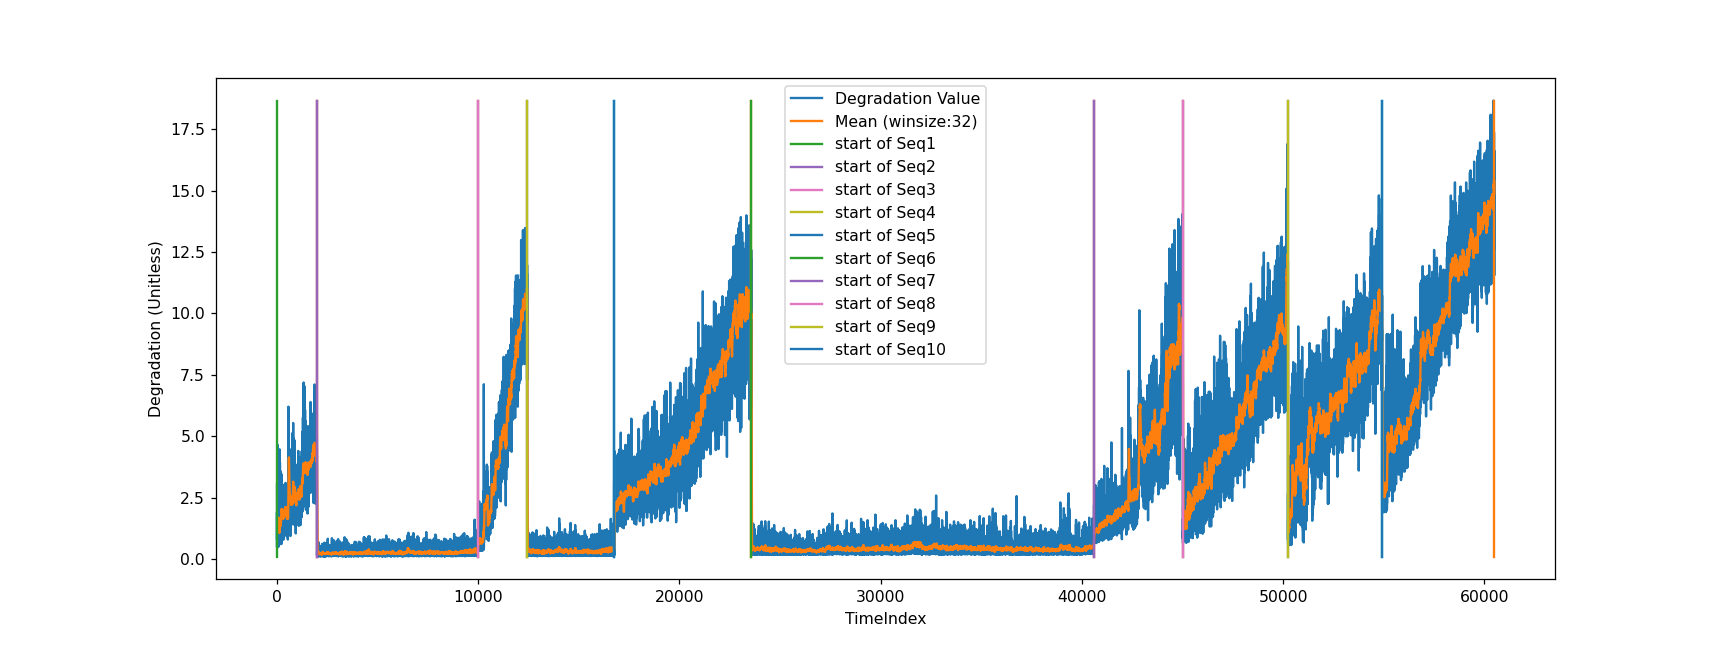

In [52]:
%matplotlib notebook
plt.plot(all_seq_y_tilde_vect, label='Degradation Value')
plt.plot(pd.Series(all_seq_y_tilde_vect).rolling(32).mean(), label='Mean (winsize:32)')

min_y = all_seq_y_tilde_vect.min()
max_y = all_seq_y_tilde_vect.max()


# Type 2 Data
seq_period_iloc = [
    [    0,  1991],
    [ 1991,  9986],
    [ 9986, 12435],
    [ 12435, 16757],
    [ 16757, 23576],
    [ 23576, 40589],
    [ 40589, 45013],
    [ 45013, 50234],
    [ 50234, 54914],
    [ 54914, 60490],
]

seq_index = 1
for stime_iloc, etime_iloc in seq_period_iloc:
    plt.plot([stime_iloc, stime_iloc], [min_y, max_y], label = "start of Seq{}".format(seq_index))
    plt.plot([etime_iloc, etime_iloc], [min_y, max_y])
    seq_index += 1


plt.ylabel("Degradation (Unitless)")
plt.xlabel("TimeIndex")

plt.legend()
plt.show()